In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install statsmodels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import time
from datetime import datetime
import joblib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

In [ ]:
# Load the data sets
train_set = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/train_set_2D.parquet", engine="pyarrow")
val_set = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/val_set_2D.parquet", engine="pyarrow")
test_set = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/test_set_2D.parquet", engine="pyarrow")
print("Train Set Shape:", train_set.shape)
print("Columns:", train_set.columns.tolist())

# Double checking that there are no NaNs in the train/val/test sets
print(f"Train set: \n{train_set.isnull().sum()}")
print(f"\nVal set: \n{val_set.isnull().sum()}")
print(f"\nTrain set: \n{test_set.isnull().sum()}")

train_set.head()

Train Set Shape: (5066592, 11)
Columns: ['lat_5km', 'lon_5km', 'KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM', 'date']
Train set: 
lat_5km    0
lon_5km    0
KD490      0
ZSD        0
RRS490     0
RRS443     0
CHL        0
MICRO      0
BBP        0
CDM        0
date       0
dtype: int64

Val set: 
lat_5km    0
lon_5km    0
KD490      0
ZSD        0
RRS490     0
RRS443     0
CHL        0
MICRO      0
BBP        0
CDM        0
date       0
dtype: int64

Train set: 
lat_5km    0
lon_5km    0
KD490      0
ZSD        0
RRS490     0
RRS443     0
CHL        0
MICRO      0
BBP        0
CDM        0
date       0
dtype: int64


lat_5km  lon_5km     KD490        ZSD    RRS490    RRS443       CHL  \
2484972    49.15   -10.75  0.045128  20.067772  0.005975  0.006162  0.226696   
2484973    49.15   -10.70  0.046286  19.458317  0.006216  0.006206  0.240509   
2484974    49.15   -10.65  0.046816  19.190926  0.005016  0.004744  0.246931   
2484975    49.15   -10.60  0.046941  19.129135  0.004528  0.004160  0.248443   
2484976    49.15   -10.55  0.047569  18.826391  0.005309  0.004928  0.256153   

            MICRO       BBP       CDM       date  
2484972  0.116628  0.003510  0.025269 2022-01-27  
2484973  0.116628  0.003727  0.025429 2022-01-27  
2484974  0.116628  0.003518  0.026799 2022-01-27  
2484975  0.116628  0.003137  0.028340 2022-01-27  
2484976  0.116628  0.003519  0.029589 2022-01-27

# **K-means + VAR for 5 models**

## Stage 1: K-means clustering

In [ ]:
def k_means_cluster(train_set, k_to_use):
    unique_lats = np.sort(train_set['lat_5km'].unique())
    unique_lons = np.sort(train_set['lon_5km'].unique())

    coords = []
    data_vectors = []

    total_points = len(unique_lats) * len(unique_lons)
    pbar = tqdm(total=total_points, desc="Scanning grid points")

    for lat in unique_lats:
        for lon in unique_lons:
            grid_ts = train_set[
                (train_set['lat_5km'] == lat) & (train_set['lon_5km'] == lon)
            ].sort_values('date').drop(['lat_5km', 'lon_5km', 'date'], axis=1)

            if len(grid_ts) == 0 or grid_ts.isnull().any().any():
                pbar.update(1)
                continue

            data_vectors.append(grid_ts.values.flatten())
            coords.append((lat, lon))
            pbar.update(1)

    pbar.close()

    # Standardize vectors
    X = StandardScaler().fit_transform(data_vectors)
    k_means = KMeans(n_clusters=k_to_use, random_state=42)
    labels = k_means.fit_predict(X)

    # Build labeled DataFrame
    cluster_df = pd.DataFrame(coords, columns=['lat_5km', 'lon_5km'])
    cluster_df['cluster'] = labels

    return cluster_df, k_means

## Stage 2: Vector AutoRegression on K-means

In [ ]:
def train_VAR_per_cluster(train_set, val_set, cluster_map, best_lag=1):
    """
    Train VAR on the mean of each cluster’s training series.
    Then produce predictions separately for each point in that cluster using
    each point’s own lagged values (for both training and validation).
    """
    val_predictions = {}
    train_predictions = {}

    clusters = defaultdict(list)
    for coord, label in cluster_map.items():
        clusters[label].append(coord)

    parameter_columns = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]

    for cluster_id in tqdm(sorted(clusters.keys()), desc="Training VAR per cluster"):
        points = clusters[cluster_id]
        if not points:
            continue

        train_series, val_series = [], []
        for lat, lon in points:
            tr = train_set[(train_set['lat_5km'] == lat) & (train_set['lon_5km'] == lon)].copy()
            vl = val_set[(val_set['lat_5km'] == lat) & (val_set['lon_5km'] == lon)].copy()
            if tr.empty:
                continue
            tr = tr.sort_values('date').drop(['lat_5km', 'lon_5km'], axis=1).set_index('date')
            vl = vl.sort_values('date').drop(['lat_5km', 'lon_5km'], axis=1).set_index('date')
            train_series.append(tr)
            val_series.append(vl)

        if not train_series:
            continue

        cluster_train_df = pd.concat(train_series).groupby('date')[parameter_columns].mean().sort_index()
        cluster_val_df   = pd.concat(val_series).groupby('date')[parameter_columns].mean().sort_index()
        cluster_train_df = cluster_train_df.reset_index(drop=True)

        try:
            model = VAR(cluster_train_df)
            result = model.fit(best_lag)
            print(f"Cluster {cluster_id}: fitted VAR({best_lag})")
        except:
            continue

        # ========== VALIDATION PREDICTIONS ========== #
        for lat, lon in points:
            vl = val_set[(val_set['lat_5km'] == lat) & (val_set['lon_5km'] == lon)].copy()
            if vl.empty:
                continue

            vl = vl.sort_values('date')
            vl_vals = vl[parameter_columns].values
            preds = []

            past_values = cluster_train_df.values.copy()
            for t in range(len(vl_vals)):
                if t < best_lag:
                    if len(past_values) >= best_lag - t:
                        history = np.vstack([past_values[-(best_lag - t):], vl_vals[:t]])
                    else:
                        preds.append(np.full(len(parameter_columns), np.nan))
                        continue
                else:
                    history = vl_vals[t - best_lag:t]

                next_pred = result.forecast(y=history, steps=1)[0]
                preds.append(next_pred)

            val_predictions[(cluster_id, lat, lon)] = np.array(preds)

        # ========== TRAINING PREDICTIONS (PER-POINT) ========== #
        for lat, lon in points:
            tr = train_set[(train_set['lat_5km'] == lat) & (train_set['lon_5km'] == lon)].copy()
            if tr.empty:
                continue

            tr = tr.sort_values('date')
            tr_vals = tr[parameter_columns].values
            preds = []

            for t in range(len(tr_vals)):
                if t < best_lag:
                    preds.append(np.full(len(parameter_columns), np.nan))
                    continue
                history = tr_vals[t - best_lag:t]
                try:
                    next_pred = result.forecast(y=history, steps=1)[0]
                except:
                    next_pred = np.full(len(parameter_columns), np.nan)
                preds.append(next_pred)

            train_predictions[(cluster_id, lat, lon)] = np.array(preds)

    return train_predictions, val_predictions

## Training Set Evaluation Metrics function

In [ ]:
def compute_train_metrics(train_predictions, train_set, parameter_columns, k_value, plot=True):
    """
    train_predictions key = (cluster_id, lat, lon)
    Compare each prediction (same for cluster) to the true values of each gridpoint.
    """
    all_pred = []
    all_true = []

    for (cluster_id, lat, lon), preds in train_predictions.items():
        # Get the corresponding true series
        group = (
            train_set[(train_set['lat_5km'] == lat) & (train_set['lon_5km'] == lon)]
            .sort_values('date')
        )

        true_vals = group[parameter_columns].values

        preds_aligned = preds[:len(true_vals)]

        if len(true_vals) == 0 or len(preds_aligned) == 0:
            continue

        all_true.append(true_vals)
        all_pred.append(preds_aligned)

    if not all_pred or not all_true:
        print("No valid training predictions available.")
        return None

    all_pred = np.vstack(all_pred)
    all_true = np.vstack(all_true)

    # Compute metrics with NaN-safe functions
    global_mape = np.nanmean(np.abs((all_true - all_pred) /
                                    np.clip(np.abs(all_true), 1e-8, None)), axis=0) * 100
    global_rmse = np.sqrt(np.nanmean((all_true - all_pred) ** 2, axis=0))
    global_mae = np.nanmean(np.abs(all_true - all_pred), axis=0)
    global_smape = np.mean(2 * np.abs(all_true - all_pred) /
                           np.clip(np.abs(all_true) + np.abs(all_pred), 1e-8, None), axis=0) * 100

    metrics_array = np.vstack([global_mape, global_smape, global_rmse, global_mae])
    metric_names = ['MAPE (%)', 'SMAPE (%)', 'RMSE', 'MAE']

    metrics_df = pd.DataFrame(
        data=metrics_array,
        columns=parameter_columns,
        index=metric_names
    )
    metrics_df['k'] = k_value

    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        plt.figure(figsize=(14, 4))
        sns.heatmap(metrics_array, annot=True, fmt=".3f",
                    xticklabels=parameter_columns, yticklabels=metric_names, cmap="coolwarm")
        plt.title(f"Global Error Metrics per Variable (Cluster VAR with k={k_value}): Training Set")
        plt.tight_layout()
        plt.show()

    return metrics_df

## Validation Set Evaluation Metrics function

In [ ]:
def compute_val_metrics(val_predictions, val_set, parameter_columns, k_value, plot=True):
    """
    val_predictions key = (cluster_id, lat, lon)
    Compare each prediction (same for cluster) to the true values of each gridpoint.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    all_pred, all_true = [], []

    for (cluster_id, lat, lon), preds in val_predictions.items():
        true_vals = (
            val_set[(val_set['cluster'] == cluster_id) &
                    (val_set['lat_5km'] == lat) &
                    (val_set['lon_5km'] == lon)]
            .sort_values('date')[parameter_columns].values
        )
        # align
        preds = preds[:len(true_vals)]
        if len(preds) == 0 or len(true_vals) == 0:
            continue
        all_pred.append(preds)
        all_true.append(true_vals)

    if not all_pred:
        print("No predictions to evaluate"); return None

    all_pred = np.vstack(all_pred)
    all_true = np.vstack(all_true)

    global_mape = np.mean(np.abs((all_true - all_pred) /
                     np.clip(np.abs(all_true), 1e-8, None)), axis=0) * 100
    rmse = np.sqrt(np.mean((all_true - all_pred) ** 2, axis=0))
    mae  = np.mean(np.abs(all_true - all_pred), axis=0)
    global_smape = np.mean(2 * np.abs(all_true - all_pred) /
                       np.clip(np.abs(all_true) + np.abs(all_pred), 1e-8, None), axis=0) * 100


    metrics = np.vstack([global_mape, global_smape, rmse, mae])
    names=['MAPE (%)','SMAPE (%)','RMSE','MAE']
    df = pd.DataFrame(metrics, columns=parameter_columns, index=names)
    df['k'] = k_value

    if plot:
        plt.figure(figsize=(14,4))
        sns.heatmap(metrics, annot=True, fmt=".3f", xticklabels=parameter_columns, yticklabels=names, cmap="coolwarm")
        plt.title(f"Validation metrics (cluster-predicted → pointwise truth), k={k_value}")
        plt.tight_layout(); plt.show()

    return df

## Run the models with different k and store the results

In [ ]:
# Required lists for running the loop
k_list = [5, 10, 15, 20, 25, 50, 75, 100]
parameter_columns = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]
train_metrics_main_df = pd.DataFrame()
val_metrics_main_df = pd.DataFrame()

# RUN THE TWO-STAGE K-MEANS + VAR FOR VARIOUS K:
for k in k_list:
    # Re-load clean sets
    train_set = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/train_set_2D.parquet", engine="pyarrow")
    val_set = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/val_set_2D.parquet", engine="pyarrow")

    # Cluster assignment
    cluster_df, kmeans_model = k_means_cluster(train_set, k_to_use=k)
    cluster_df['cluster'] = cluster_df['cluster'].astype(int)
    cluster_map = {
        (row['lat_5km'], row['lon_5km']): row['cluster']
        for _, row in cluster_df.iterrows()
    }

    # Run two-stage VAR
    train_predictions, val_predictions = train_VAR_per_cluster(train_set, val_set, cluster_map)

    # Attach clusters
    train_set = train_set.merge(cluster_df, on=['lat_5km', 'lon_5km'], how='left')
    val_set = val_set.merge(cluster_df, on=['lat_5km', 'lon_5km'], how='left')

    # Evaluate training set error metrics
    train_metrics = compute_train_metrics(train_predictions, train_set, parameter_columns, k, plot=False)
    if train_metrics is not None:
        train_metrics_main_df = pd.concat([train_metrics_main_df, train_metrics])

    # Evaluate validation set error metrics
    val_metrics = compute_val_metrics(val_predictions, val_set, parameter_columns, k, plot=False)
    if val_metrics is not None:
        val_metrics_main_df = pd.concat([val_metrics_main_df, val_metrics])

Training VAR per cluster:   0%|          | 0/5 [00:00<?, ?it/s]

Cluster 0.0: fitted VAR(1)


Training VAR per cluster:  20%|██        | 1/5 [00:38<02:35, 38.99s/it]

Cluster 1.0: fitted VAR(1)


Training VAR per cluster:  40%|████      | 2/5 [00:40<00:51, 17.10s/it]

Cluster 2.0: fitted VAR(1)


Training VAR per cluster:  60%|██████    | 3/5 [01:15<00:50, 25.09s/it]

Cluster 3.0: fitted VAR(1)


Training VAR per cluster:  80%|████████  | 4/5 [01:27<00:19, 19.79s/it]

Cluster 4.0: fitted VAR(1)


Training VAR per cluster:   0%|          | 0/10 [00:00<?, ?it/s]

Cluster 0.0: fitted VAR(1)


Training VAR per cluster:  10%|█         | 1/10 [00:12<01:51, 12.35s/it]

Cluster 1.0: fitted VAR(1)


Training VAR per cluster:  20%|██        | 2/10 [00:14<00:52,  6.53s/it]

Cluster 2.0: fitted VAR(1)


Training VAR per cluster:  30%|███       | 3/10 [00:31<01:17, 11.11s/it]

Cluster 3.0: fitted VAR(1)


Training VAR per cluster:  40%|████      | 4/10 [00:46<01:16, 12.71s/it]

Cluster 4.0: fitted VAR(1)


Training VAR per cluster:  50%|█████     | 5/10 [01:02<01:10, 14.01s/it]

Cluster 5.0: fitted VAR(1)


Training VAR per cluster:  60%|██████    | 6/10 [01:18<00:58, 14.52s/it]

Cluster 6.0: fitted VAR(1)


Training VAR per cluster:  70%|███████   | 7/10 [01:41<00:52, 17.37s/it]

Cluster 7.0: fitted VAR(1)


Training VAR per cluster:  80%|████████  | 8/10 [01:42<00:24, 12.07s/it]

Cluster 8.0: fitted VAR(1)


Training VAR per cluster:  90%|█████████ | 9/10 [01:43<00:08,  8.63s/it]

Cluster 9.0: fitted VAR(1)


Training VAR per cluster:   0%|          | 0/15 [00:00<?, ?it/s]

Cluster 0.0: fitted VAR(1)


Training VAR per cluster:   7%|▋         | 1/15 [00:10<02:23, 10.22s/it]

Cluster 1.0: fitted VAR(1)


Training VAR per cluster:  13%|█▎        | 2/15 [00:12<01:11,  5.51s/it]

Cluster 2.0: fitted VAR(1)


Training VAR per cluster:  20%|██        | 3/15 [00:21<01:25,  7.08s/it]

Cluster 3.0: fitted VAR(1)


Training VAR per cluster:  27%|██▋       | 4/15 [00:35<01:47,  9.80s/it]

Cluster 4.0: fitted VAR(1)


Training VAR per cluster:  33%|███▎      | 5/15 [00:48<01:50, 11.04s/it]

Cluster 5.0: fitted VAR(1)


Training VAR per cluster:  40%|████      | 6/15 [01:00<01:42, 11.35s/it]

Cluster 6.0: fitted VAR(1)


Training VAR per cluster:  47%|████▋     | 7/15 [01:08<01:22, 10.26s/it]

Cluster 7.0: fitted VAR(1)


Training VAR per cluster:  53%|█████▎    | 8/15 [01:09<00:50,  7.24s/it]

Cluster 8.0: fitted VAR(1)


Training VAR per cluster:  60%|██████    | 9/15 [01:10<00:31,  5.27s/it]

Cluster 9.0: fitted VAR(1)


Training VAR per cluster:  67%|██████▋   | 10/15 [01:16<00:28,  5.62s/it]

Cluster 10.0: fitted VAR(1)


Training VAR per cluster:  73%|███████▎  | 11/15 [01:27<00:29,  7.30s/it]

Cluster 11.0: fitted VAR(1)


Training VAR per cluster:  80%|████████  | 12/15 [01:42<00:28,  9.60s/it]

Cluster 12.0: fitted VAR(1)


Training VAR per cluster:  93%|█████████▎| 14/15 [01:50<00:06,  6.37s/it]

Cluster 13.0: fitted VAR(1)
Cluster 14.0: fitted VAR(1)


Training VAR per cluster:   0%|          | 0/20 [00:00<?, ?it/s]

Cluster 0.0: fitted VAR(1)


Training VAR per cluster:   5%|▌         | 1/20 [00:06<02:10,  6.87s/it]

Cluster 1.0: fitted VAR(1)


Training VAR per cluster:  10%|█         | 2/20 [00:08<01:12,  4.03s/it]

Cluster 2.0: fitted VAR(1)


Training VAR per cluster:  15%|█▌        | 3/20 [00:17<01:44,  6.15s/it]

Cluster 3.0: fitted VAR(1)


Training VAR per cluster:  20%|██        | 4/20 [00:26<01:55,  7.20s/it]

Cluster 4.0: fitted VAR(1)


Training VAR per cluster:  25%|██▌       | 5/20 [00:38<02:12,  8.81s/it]

Cluster 5.0: fitted VAR(1)


Training VAR per cluster:  30%|███       | 6/20 [00:40<01:32,  6.60s/it]

Cluster 6.0: fitted VAR(1)


Training VAR per cluster:  35%|███▌      | 7/20 [00:48<01:30,  7.00s/it]

Cluster 7.0: fitted VAR(1)


Training VAR per cluster:  40%|████      | 8/20 [00:48<00:58,  4.91s/it]

Cluster 8.0: fitted VAR(1)


Training VAR per cluster:  45%|████▌     | 9/20 [00:49<00:40,  3.64s/it]

Cluster 9.0: fitted VAR(1)


Training VAR per cluster:  50%|█████     | 10/20 [00:53<00:38,  3.86s/it]

Cluster 10.0: fitted VAR(1)


Training VAR per cluster:  55%|█████▌    | 11/20 [01:03<00:51,  5.76s/it]

Cluster 11.0: fitted VAR(1)


Training VAR per cluster:  60%|██████    | 12/20 [01:16<01:02,  7.80s/it]

Cluster 12.0: fitted VAR(1)


Training VAR per cluster:  70%|███████   | 14/20 [01:24<00:32,  5.49s/it]

Cluster 13.0: fitted VAR(1)
Cluster 14.0: fitted VAR(1)


Training VAR per cluster:  75%|███████▌  | 15/20 [01:28<00:25,  5.03s/it]

Cluster 15.0: fitted VAR(1)


Training VAR per cluster:  80%|████████  | 16/20 [01:32<00:18,  4.73s/it]

Cluster 16.0: fitted VAR(1)


Training VAR per cluster:  85%|████████▌ | 17/20 [01:40<00:17,  5.87s/it]

Cluster 17.0: fitted VAR(1)


Training VAR per cluster:  90%|█████████ | 18/20 [01:46<00:11,  5.72s/it]

Cluster 18.0: fitted VAR(1)


Training VAR per cluster:  95%|█████████▌| 19/20 [01:55<00:06,  6.90s/it]

Cluster 19.0: fitted VAR(1)


Training VAR per cluster:   0%|          | 0/25 [00:00<?, ?it/s]

Cluster 0.0: fitted VAR(1)


Training VAR per cluster:   4%|▍         | 1/25 [00:06<02:46,  6.95s/it]

Cluster 1.0: fitted VAR(1)


Training VAR per cluster:   8%|▊         | 2/25 [00:08<01:27,  3.82s/it]

Cluster 2.0: fitted VAR(1)


Training VAR per cluster:  12%|█▏        | 3/25 [00:17<02:12,  6.03s/it]

Cluster 3.0: fitted VAR(1)


Training VAR per cluster:  16%|█▌        | 4/25 [00:21<01:50,  5.26s/it]

Cluster 4.0: fitted VAR(1)


Training VAR per cluster:  20%|██        | 5/25 [00:21<01:11,  3.56s/it]

Cluster 5.0: fitted VAR(1)


Training VAR per cluster:  24%|██▍       | 6/25 [00:26<01:12,  3.79s/it]

Cluster 6.0: fitted VAR(1)


Training VAR per cluster:  28%|██▊       | 7/25 [00:33<01:28,  4.90s/it]

Cluster 7.0: fitted VAR(1)


Training VAR per cluster:  32%|███▏      | 8/25 [00:41<01:39,  5.84s/it]

Cluster 8.0: fitted VAR(1)


Training VAR per cluster:  36%|███▌      | 9/25 [00:51<01:57,  7.37s/it]

Cluster 9.0: fitted VAR(1)


Training VAR per cluster:  40%|████      | 10/25 [00:52<01:20,  5.37s/it]

Cluster 10.0: fitted VAR(1)


Training VAR per cluster:  44%|████▍     | 11/25 [00:56<01:07,  4.79s/it]

Cluster 11.0: fitted VAR(1)


Training VAR per cluster:  48%|████▊     | 12/25 [01:00<01:01,  4.70s/it]

Cluster 12.0: fitted VAR(1)


Training VAR per cluster:  52%|█████▏    | 13/25 [01:07<01:02,  5.20s/it]

Cluster 13.0: fitted VAR(1)


Training VAR per cluster:  56%|█████▌    | 14/25 [01:14<01:03,  5.80s/it]

Cluster 14.0: fitted VAR(1)


Training VAR per cluster:  60%|██████    | 15/25 [01:21<01:03,  6.31s/it]

Cluster 15.0: fitted VAR(1)


Training VAR per cluster:  64%|██████▍   | 16/25 [01:26<00:52,  5.86s/it]

Cluster 16.0: fitted VAR(1)


Training VAR per cluster:  68%|██████▊   | 17/25 [01:30<00:42,  5.25s/it]

Cluster 17.0: fitted VAR(1)


Training VAR per cluster:  72%|███████▏  | 18/25 [01:32<00:30,  4.40s/it]

Cluster 18.0: fitted VAR(1)


Training VAR per cluster:  80%|████████  | 20/25 [01:33<00:11,  2.30s/it]

Cluster 19.0: fitted VAR(1)
Cluster 20.0: fitted VAR(1)


Training VAR per cluster:  84%|████████▍ | 21/25 [01:36<00:10,  2.53s/it]

Cluster 21.0: fitted VAR(1)


Training VAR per cluster:  88%|████████▊ | 22/25 [01:44<00:12,  4.08s/it]

Cluster 22.0: fitted VAR(1)


Training VAR per cluster:  92%|█████████▏| 23/25 [01:51<00:09,  4.97s/it]

Cluster 23.0: fitted VAR(1)


Training VAR per cluster:  96%|█████████▌| 24/25 [01:51<00:03,  3.61s/it]

Cluster 24.0: fitted VAR(1)


Training VAR per cluster:   0%|          | 0/50 [00:00<?, ?it/s]

Cluster 0.0: fitted VAR(1)


Training VAR per cluster:   2%|▏         | 1/50 [00:03<02:33,  3.13s/it]

Cluster 1.0: fitted VAR(1)


Training VAR per cluster:   4%|▍         | 2/50 [00:04<01:35,  1.99s/it]

Cluster 2.0: fitted VAR(1)


Training VAR per cluster:   6%|▌         | 3/50 [00:09<02:38,  3.38s/it]

Cluster 3.0: fitted VAR(1)


Training VAR per cluster:   8%|▊         | 4/50 [00:12<02:23,  3.12s/it]

Cluster 4.0: fitted VAR(1)


Training VAR per cluster:  10%|█         | 5/50 [00:12<01:35,  2.13s/it]

Cluster 5.0: fitted VAR(1)


Training VAR per cluster:  12%|█▏        | 6/50 [00:16<02:01,  2.76s/it]

Cluster 6.0: fitted VAR(1)


Training VAR per cluster:  14%|█▍        | 7/50 [00:19<01:58,  2.75s/it]

Cluster 7.0: fitted VAR(1)


Training VAR per cluster:  16%|█▌        | 8/50 [00:20<01:37,  2.33s/it]

Cluster 8.0: fitted VAR(1)


Training VAR per cluster:  18%|█▊        | 9/50 [00:25<02:05,  3.06s/it]

Cluster 9.0: fitted VAR(1)


Training VAR per cluster:  20%|██        | 10/50 [00:25<01:31,  2.30s/it]

Cluster 10.0: fitted VAR(1)


Training VAR per cluster:  22%|██▏       | 11/50 [00:28<01:35,  2.44s/it]

Cluster 11.0: fitted VAR(1)


Training VAR per cluster:  24%|██▍       | 12/50 [00:30<01:26,  2.27s/it]

Cluster 12.0: fitted VAR(1)


Training VAR per cluster:  26%|██▌       | 13/50 [00:33<01:27,  2.37s/it]

Cluster 13.0: fitted VAR(1)


Training VAR per cluster:  28%|██▊       | 14/50 [00:37<01:50,  3.06s/it]

Cluster 14.0: fitted VAR(1)


Training VAR per cluster:  30%|███       | 15/50 [00:40<01:46,  3.04s/it]

Cluster 15.0: fitted VAR(1)


Training VAR per cluster:  32%|███▏      | 16/50 [00:43<01:43,  3.04s/it]

Cluster 16.0: fitted VAR(1)


Training VAR per cluster:  34%|███▍      | 17/50 [00:46<01:33,  2.84s/it]

Cluster 17.0: fitted VAR(1)


Training VAR per cluster:  38%|███▊      | 19/50 [00:48<00:57,  1.87s/it]

Cluster 18.0: fitted VAR(1)


Training VAR per cluster:  40%|████      | 20/50 [00:48<00:41,  1.38s/it]

Cluster 19.0: fitted VAR(1)
Cluster 20.0: fitted VAR(1)


Training VAR per cluster:  42%|████▏     | 21/50 [00:51<00:52,  1.81s/it]

Cluster 21.0: fitted VAR(1)


Training VAR per cluster:  44%|████▍     | 22/50 [00:55<01:12,  2.60s/it]

Cluster 22.0: fitted VAR(1)


Training VAR per cluster:  48%|████▊     | 24/50 [01:00<01:01,  2.37s/it]

Cluster 23.0: fitted VAR(1)
Cluster 24.0: fitted VAR(1)


Training VAR per cluster:  50%|█████     | 25/50 [01:02<00:49,  1.99s/it]

Cluster 25.0: fitted VAR(1)


Training VAR per cluster:  52%|█████▏    | 26/50 [01:04<00:52,  2.18s/it]

Cluster 26.0: fitted VAR(1)


Training VAR per cluster:  54%|█████▍    | 27/50 [01:08<01:01,  2.67s/it]

Cluster 27.0: fitted VAR(1)


Training VAR per cluster:  56%|█████▌    | 28/50 [01:11<01:00,  2.75s/it]

Cluster 28.0: fitted VAR(1)


Training VAR per cluster:  58%|█████▊    | 29/50 [01:13<00:51,  2.43s/it]

Cluster 29.0: fitted VAR(1)


Training VAR per cluster:  60%|██████    | 30/50 [01:15<00:47,  2.39s/it]

Cluster 30.0: fitted VAR(1)


Training VAR per cluster:  62%|██████▏   | 31/50 [01:21<01:03,  3.36s/it]

Cluster 31.0: fitted VAR(1)


Training VAR per cluster:  64%|██████▍   | 32/50 [01:23<00:55,  3.08s/it]

Cluster 32.0: fitted VAR(1)


Training VAR per cluster:  68%|██████▊   | 34/50 [01:26<00:34,  2.15s/it]

Cluster 33.0: fitted VAR(1)
Cluster 34.0: fitted VAR(1)


Training VAR per cluster:  70%|███████   | 35/50 [01:30<00:39,  2.65s/it]

Cluster 35.0: fitted VAR(1)


Training VAR per cluster:  72%|███████▏  | 36/50 [01:32<00:36,  2.64s/it]

Cluster 36.0: fitted VAR(1)


Training VAR per cluster:  74%|███████▍  | 37/50 [01:36<00:39,  3.01s/it]

Cluster 37.0: fitted VAR(1)


Training VAR per cluster:  78%|███████▊  | 39/50 [01:38<00:19,  1.82s/it]

Cluster 38.0: fitted VAR(1)


Training VAR per cluster:  80%|████████  | 40/50 [01:38<00:13,  1.35s/it]

Cluster 39.0: fitted VAR(1)


Training VAR per cluster:  82%|████████▏ | 41/50 [01:38<00:09,  1.02s/it]

Cluster 40.0: fitted VAR(1)
Cluster 41.0: fitted VAR(1)


Training VAR per cluster:  84%|████████▍ | 42/50 [01:41<00:11,  1.41s/it]

Cluster 42.0: fitted VAR(1)


Training VAR per cluster:  86%|████████▌ | 43/50 [01:41<00:07,  1.10s/it]

Cluster 43.0: fitted VAR(1)


Training VAR per cluster:  88%|████████▊ | 44/50 [01:44<00:10,  1.70s/it]

Cluster 44.0: fitted VAR(1)


Training VAR per cluster:  90%|█████████ | 45/50 [01:45<00:07,  1.48s/it]

Cluster 45.0: fitted VAR(1)


Training VAR per cluster:  92%|█████████▏| 46/50 [01:47<00:06,  1.71s/it]

Cluster 46.0: fitted VAR(1)
Cluster 47.0: fitted VAR(1)


Training VAR per cluster:  96%|█████████▌| 48/50 [01:49<00:02,  1.27s/it]

Cluster 48.0: fitted VAR(1)


Training VAR per cluster:  98%|█████████▊| 49/50 [01:52<00:01,  1.76s/it]

Cluster 49.0: fitted VAR(1)


Training VAR per cluster:   0%|          | 0/75 [00:00<?, ?it/s]

Cluster 0.0: fitted VAR(1)


Training VAR per cluster:   1%|▏         | 1/75 [00:03<03:43,  3.02s/it]

Cluster 1.0: fitted VAR(1)


Training VAR per cluster:   3%|▎         | 2/75 [00:03<01:50,  1.51s/it]

Cluster 2.0: fitted VAR(1)


Training VAR per cluster:   4%|▍         | 3/75 [00:06<02:51,  2.38s/it]

Cluster 3.0: fitted VAR(1)


Training VAR per cluster:   5%|▌         | 4/75 [00:08<02:15,  1.91s/it]

Cluster 4.0: fitted VAR(1)


Training VAR per cluster:   8%|▊         | 6/75 [00:08<01:06,  1.04it/s]

Cluster 5.0: fitted VAR(1)
Cluster 6.0: fitted VAR(1)


Training VAR per cluster:   9%|▉         | 7/75 [00:09<00:57,  1.18it/s]

Cluster 7.0: fitted VAR(1)


Training VAR per cluster:  11%|█         | 8/75 [00:11<01:31,  1.36s/it]

Cluster 8.0: fitted VAR(1)


Training VAR per cluster:  12%|█▏        | 9/75 [00:14<01:53,  1.73s/it]

Cluster 9.0: fitted VAR(1)


Training VAR per cluster:  13%|█▎        | 10/75 [00:15<01:42,  1.57s/it]

Cluster 10.0: fitted VAR(1)


Training VAR per cluster:  15%|█▍        | 11/75 [00:17<01:41,  1.58s/it]

Cluster 11.0: fitted VAR(1)


Training VAR per cluster:  16%|█▌        | 12/75 [00:18<01:38,  1.56s/it]

Cluster 12.0: fitted VAR(1)


Training VAR per cluster:  17%|█▋        | 13/75 [00:19<01:20,  1.31s/it]

Cluster 13.0: fitted VAR(1)


Training VAR per cluster:  19%|█▊        | 14/75 [00:22<01:59,  1.97s/it]

Cluster 14.0: fitted VAR(1)


Training VAR per cluster:  20%|██        | 15/75 [00:25<02:06,  2.11s/it]

Cluster 15.0: fitted VAR(1)


Training VAR per cluster:  21%|██▏       | 16/75 [00:26<01:43,  1.76s/it]

Cluster 16.0: fitted VAR(1)


Training VAR per cluster:  23%|██▎       | 17/75 [00:28<01:54,  1.97s/it]

Cluster 17.0: fitted VAR(1)


Training VAR per cluster:  25%|██▌       | 19/75 [00:33<01:46,  1.90s/it]

Cluster 18.0: fitted VAR(1)
Cluster 19.0: fitted VAR(1)


Training VAR per cluster:  27%|██▋       | 20/75 [00:34<01:31,  1.66s/it]

Cluster 20.0: fitted VAR(1)


Training VAR per cluster:  28%|██▊       | 21/75 [00:35<01:30,  1.67s/it]

Cluster 21.0: fitted VAR(1)


Training VAR per cluster:  29%|██▉       | 22/75 [00:38<01:41,  1.92s/it]

Cluster 22.0: fitted VAR(1)


Training VAR per cluster:  31%|███       | 23/75 [00:40<01:37,  1.88s/it]

Cluster 23.0: fitted VAR(1)


Training VAR per cluster:  32%|███▏      | 24/75 [00:41<01:21,  1.60s/it]

Cluster 24.0: fitted VAR(1)


Training VAR per cluster:  33%|███▎      | 25/75 [00:44<01:40,  2.01s/it]

Cluster 25.0: fitted VAR(1)


Training VAR per cluster:  36%|███▌      | 27/75 [00:46<01:09,  1.46s/it]

Cluster 26.0: fitted VAR(1)
Cluster 27.0: fitted VAR(1)


Training VAR per cluster:  37%|███▋      | 28/75 [00:48<01:21,  1.73s/it]

Cluster 28.0: fitted VAR(1)


Training VAR per cluster:  40%|████      | 30/75 [00:51<01:08,  1.52s/it]

Cluster 29.0: fitted VAR(1)
Cluster 30.0: fitted VAR(1)


Training VAR per cluster:  41%|████▏     | 31/75 [00:54<01:19,  1.81s/it]

Cluster 31.0: fitted VAR(1)


Training VAR per cluster:  43%|████▎     | 32/75 [00:55<01:18,  1.83s/it]

Cluster 32.0: fitted VAR(1)


Training VAR per cluster:  44%|████▍     | 33/75 [00:59<01:40,  2.39s/it]

Cluster 33.0: fitted VAR(1)


Training VAR per cluster:  45%|████▌     | 34/75 [01:00<01:21,  1.99s/it]

Cluster 34.0: fitted VAR(1)


Training VAR per cluster:  47%|████▋     | 35/75 [01:01<01:03,  1.59s/it]

Cluster 35.0: fitted VAR(1)


Training VAR per cluster:  48%|████▊     | 36/75 [01:03<01:10,  1.81s/it]

Cluster 36.0: fitted VAR(1)


Training VAR per cluster:  51%|█████     | 38/75 [01:06<00:51,  1.39s/it]

Cluster 37.0: fitted VAR(1)
Cluster 38.0: fitted VAR(1)


Training VAR per cluster:  55%|█████▍    | 41/75 [01:06<00:21,  1.55it/s]

Cluster 39.0: fitted VAR(1)
Cluster 40.0: fitted VAR(1)
Cluster 41.0: fitted VAR(1)
Cluster 42.0: fitted VAR(1)


Training VAR per cluster:  57%|█████▋    | 43/75 [01:09<00:32,  1.03s/it]

Cluster 43.0: fitted VAR(1)


Training VAR per cluster:  60%|██████    | 45/75 [01:11<00:28,  1.04it/s]

Cluster 44.0: fitted VAR(1)
Cluster 45.0: fitted VAR(1)


Training VAR per cluster:  61%|██████▏   | 46/75 [01:13<00:33,  1.15s/it]

Cluster 46.0: fitted VAR(1)


Training VAR per cluster:  63%|██████▎   | 47/75 [01:16<00:45,  1.63s/it]

Cluster 47.0: fitted VAR(1)


Training VAR per cluster:  64%|██████▍   | 48/75 [01:17<00:37,  1.39s/it]

Cluster 48.0: fitted VAR(1)


Training VAR per cluster:  65%|██████▌   | 49/75 [01:17<00:29,  1.13s/it]

Cluster 49.0: fitted VAR(1)


Training VAR per cluster:  67%|██████▋   | 50/75 [01:19<00:35,  1.41s/it]

Cluster 50.0: fitted VAR(1)


Training VAR per cluster:  69%|██████▉   | 52/75 [01:22<00:29,  1.30s/it]

Cluster 51.0: fitted VAR(1)
Cluster 52.0: fitted VAR(1)


Training VAR per cluster:  72%|███████▏  | 54/75 [01:25<00:27,  1.33s/it]

Cluster 53.0: fitted VAR(1)


Training VAR per cluster:  73%|███████▎  | 55/75 [01:26<00:19,  1.02it/s]

Cluster 54.0: fitted VAR(1)
Cluster 55.0: fitted VAR(1)


Training VAR per cluster:  75%|███████▍  | 56/75 [01:27<00:19,  1.04s/it]

Cluster 56.0: fitted VAR(1)


Training VAR per cluster:  76%|███████▌  | 57/75 [01:29<00:27,  1.50s/it]

Cluster 57.0: fitted VAR(1)


Training VAR per cluster:  79%|███████▊  | 59/75 [01:33<00:25,  1.60s/it]

Cluster 58.0: fitted VAR(1)
Cluster 59.0: fitted VAR(1)


Training VAR per cluster:  80%|████████  | 60/75 [01:35<00:23,  1.57s/it]

Cluster 60.0: fitted VAR(1)


Training VAR per cluster:  81%|████████▏ | 61/75 [01:36<00:20,  1.43s/it]

Cluster 61.0: fitted VAR(1)


Training VAR per cluster:  83%|████████▎ | 62/75 [01:37<00:16,  1.25s/it]

Cluster 62.0: fitted VAR(1)


Training VAR per cluster:  84%|████████▍ | 63/75 [01:38<00:16,  1.39s/it]

Cluster 63.0: fitted VAR(1)


Training VAR per cluster:  85%|████████▌ | 64/75 [01:39<00:12,  1.13s/it]

Cluster 64.0: fitted VAR(1)


Training VAR per cluster:  87%|████████▋ | 65/75 [01:41<00:14,  1.40s/it]

Cluster 65.0: fitted VAR(1)


Training VAR per cluster:  88%|████████▊ | 66/75 [01:42<00:12,  1.37s/it]

Cluster 66.0: fitted VAR(1)
Cluster 67.0: fitted VAR(1)


Training VAR per cluster:  91%|█████████ | 68/75 [01:45<00:09,  1.32s/it]

Cluster 68.0: fitted VAR(1)


Training VAR per cluster:  92%|█████████▏| 69/75 [01:49<00:11,  1.92s/it]

Cluster 69.0: fitted VAR(1)


Training VAR per cluster:  93%|█████████▎| 70/75 [01:52<00:11,  2.32s/it]

Cluster 70.0: fitted VAR(1)


Training VAR per cluster:  95%|█████████▍| 71/75 [01:54<00:08,  2.18s/it]

Cluster 71.0: fitted VAR(1)


Training VAR per cluster:  96%|█████████▌| 72/75 [01:54<00:05,  1.73s/it]

Cluster 72.0: fitted VAR(1)


Training VAR per cluster:  97%|█████████▋| 73/75 [01:56<00:03,  1.55s/it]

Cluster 73.0: fitted VAR(1)


Training VAR per cluster: 100%|██████████| 75/75 [01:57<00:00,  1.57s/it]


Cluster 74.0: fitted VAR(1)


Training VAR per cluster:   0%|          | 0/100 [00:00<?, ?it/s]

Cluster 0.0: fitted VAR(1)


Training VAR per cluster:   1%|          | 1/100 [00:01<02:13,  1.35s/it]

Cluster 1.0: fitted VAR(1)


Training VAR per cluster:   2%|▏         | 2/100 [00:01<01:22,  1.20it/s]

Cluster 2.0: fitted VAR(1)


Training VAR per cluster:   3%|▎         | 3/100 [00:04<02:57,  1.83s/it]

Cluster 3.0: fitted VAR(1)


Training VAR per cluster:   4%|▍         | 4/100 [00:05<02:20,  1.46s/it]

Cluster 4.0: fitted VAR(1)


Training VAR per cluster:   6%|▌         | 6/100 [00:06<01:12,  1.30it/s]

Cluster 5.0: fitted VAR(1)
Cluster 6.0: fitted VAR(1)


Training VAR per cluster:   7%|▋         | 7/100 [00:06<01:03,  1.47it/s]

Cluster 7.0: fitted VAR(1)


Training VAR per cluster:   8%|▊         | 8/100 [00:08<01:36,  1.05s/it]

Cluster 8.0: fitted VAR(1)


Training VAR per cluster:   9%|▉         | 9/100 [00:10<01:52,  1.24s/it]

Cluster 9.0: fitted VAR(1)


Training VAR per cluster:  10%|█         | 10/100 [00:11<01:54,  1.28s/it]

Cluster 10.0: fitted VAR(1)


Training VAR per cluster:  11%|█         | 11/100 [00:12<01:38,  1.11s/it]

Cluster 11.0: fitted VAR(1)


Training VAR per cluster:  12%|█▏        | 12/100 [00:13<01:45,  1.19s/it]

Cluster 12.0: fitted VAR(1)


Training VAR per cluster:  13%|█▎        | 13/100 [00:14<01:27,  1.01s/it]

Cluster 13.0: fitted VAR(1)


Training VAR per cluster:  14%|█▍        | 14/100 [00:17<02:17,  1.60s/it]

Cluster 14.0: fitted VAR(1)


Training VAR per cluster:  15%|█▌        | 15/100 [00:18<02:17,  1.61s/it]

Cluster 15.0: fitted VAR(1)


Training VAR per cluster:  16%|█▌        | 16/100 [00:19<01:52,  1.33s/it]

Cluster 16.0: fitted VAR(1)


Training VAR per cluster:  17%|█▋        | 17/100 [00:20<01:43,  1.24s/it]

Cluster 17.0: fitted VAR(1)


Training VAR per cluster:  19%|█▉        | 19/100 [00:23<01:38,  1.22s/it]

Cluster 18.0: fitted VAR(1)
Cluster 19.0: fitted VAR(1)


Training VAR per cluster:  20%|██        | 20/100 [00:24<01:33,  1.16s/it]

Cluster 20.0: fitted VAR(1)


Training VAR per cluster:  21%|██        | 21/100 [00:26<01:41,  1.29s/it]

Cluster 21.0: fitted VAR(1)


Training VAR per cluster:  22%|██▏       | 22/100 [00:27<01:49,  1.40s/it]

Cluster 22.0: fitted VAR(1)


Training VAR per cluster:  23%|██▎       | 23/100 [00:29<01:46,  1.39s/it]

Cluster 23.0: fitted VAR(1)


Training VAR per cluster:  24%|██▍       | 24/100 [00:29<01:23,  1.10s/it]

Cluster 24.0: fitted VAR(1)


Training VAR per cluster:  25%|██▌       | 25/100 [00:31<01:37,  1.31s/it]

Cluster 25.0: fitted VAR(1)


Training VAR per cluster:  27%|██▋       | 27/100 [00:33<01:14,  1.02s/it]

Cluster 26.0: fitted VAR(1)
Cluster 27.0: fitted VAR(1)


Training VAR per cluster:  28%|██▊       | 28/100 [00:34<01:15,  1.05s/it]

Cluster 28.0: fitted VAR(1)


Training VAR per cluster:  30%|███       | 30/100 [00:36<01:13,  1.05s/it]

Cluster 29.0: fitted VAR(1)
Cluster 30.0: fitted VAR(1)


Training VAR per cluster:  31%|███       | 31/100 [00:38<01:21,  1.18s/it]

Cluster 31.0: fitted VAR(1)


Training VAR per cluster:  32%|███▏      | 32/100 [00:39<01:27,  1.29s/it]

Cluster 32.0: fitted VAR(1)


Training VAR per cluster:  33%|███▎      | 33/100 [00:42<01:48,  1.62s/it]

Cluster 33.0: fitted VAR(1)


Training VAR per cluster:  34%|███▍      | 34/100 [00:42<01:32,  1.40s/it]

Cluster 34.0: fitted VAR(1)


Training VAR per cluster:  35%|███▌      | 35/100 [00:43<01:16,  1.17s/it]

Cluster 35.0: fitted VAR(1)


Training VAR per cluster:  36%|███▌      | 36/100 [00:45<01:24,  1.31s/it]

Cluster 36.0: fitted VAR(1)


Training VAR per cluster:  38%|███▊      | 38/100 [00:47<01:10,  1.14s/it]

Cluster 37.0: fitted VAR(1)
Cluster 38.0: fitted VAR(1)


Training VAR per cluster:  42%|████▏     | 42/100 [00:48<00:25,  2.30it/s]

Cluster 39.0: fitted VAR(1)
Cluster 40.0: fitted VAR(1)
Cluster 41.0: fitted VAR(1)
Cluster 42.0: fitted VAR(1)


Training VAR per cluster:  43%|████▎     | 43/100 [00:51<00:56,  1.01it/s]

Cluster 43.0: fitted VAR(1)


Training VAR per cluster:  45%|████▌     | 45/100 [00:53<00:51,  1.07it/s]

Cluster 44.0: fitted VAR(1)
Cluster 45.0: fitted VAR(1)


Training VAR per cluster:  46%|████▌     | 46/100 [00:54<00:55,  1.03s/it]

Cluster 46.0: fitted VAR(1)


Training VAR per cluster:  47%|████▋     | 47/100 [00:57<01:18,  1.48s/it]

Cluster 47.0: fitted VAR(1)


Training VAR per cluster:  48%|████▊     | 48/100 [00:57<01:06,  1.27s/it]

Cluster 48.0: fitted VAR(1)


Training VAR per cluster:  49%|████▉     | 49/100 [00:58<00:53,  1.05s/it]

Cluster 49.0: fitted VAR(1)


Training VAR per cluster:  50%|█████     | 50/100 [01:00<01:04,  1.29s/it]

Cluster 50.0: fitted VAR(1)


Training VAR per cluster:  52%|█████▏    | 52/100 [01:02<00:57,  1.19s/it]

Cluster 51.0: fitted VAR(1)
Cluster 52.0: fitted VAR(1)


Training VAR per cluster:  54%|█████▍    | 54/100 [01:05<00:55,  1.21s/it]

Cluster 53.0: fitted VAR(1)


Training VAR per cluster:  55%|█████▌    | 55/100 [01:05<00:40,  1.10it/s]

Cluster 54.0: fitted VAR(1)
Cluster 55.0: fitted VAR(1)


Training VAR per cluster:  56%|█████▌    | 56/100 [01:06<00:40,  1.08it/s]

Cluster 56.0: fitted VAR(1)


Training VAR per cluster:  57%|█████▋    | 57/100 [01:09<00:57,  1.33s/it]

Cluster 57.0: fitted VAR(1)


Training VAR per cluster:  59%|█████▉    | 59/100 [01:12<00:59,  1.46s/it]

Cluster 58.0: fitted VAR(1)
Cluster 59.0: fitted VAR(1)


Training VAR per cluster:  60%|██████    | 60/100 [01:14<00:57,  1.45s/it]

Cluster 60.0: fitted VAR(1)


Training VAR per cluster:  61%|██████    | 61/100 [01:15<00:49,  1.28s/it]

Cluster 61.0: fitted VAR(1)


Training VAR per cluster:  62%|██████▏   | 62/100 [01:16<00:42,  1.12s/it]

Cluster 62.0: fitted VAR(1)


Training VAR per cluster:  63%|██████▎   | 63/100 [01:17<00:44,  1.20s/it]

Cluster 63.0: fitted VAR(1)


Training VAR per cluster:  64%|██████▍   | 64/100 [01:17<00:34,  1.05it/s]

Cluster 64.0: fitted VAR(1)


Training VAR per cluster:  65%|██████▌   | 65/100 [01:19<00:41,  1.18s/it]

Cluster 65.0: fitted VAR(1)


Training VAR per cluster:  66%|██████▌   | 66/100 [01:20<00:42,  1.25s/it]

Cluster 66.0: fitted VAR(1)
Cluster 67.0: fitted VAR(1)


Training VAR per cluster:  68%|██████▊   | 68/100 [01:22<00:33,  1.05s/it]

Cluster 68.0: fitted VAR(1)


Training VAR per cluster:  69%|██████▉   | 69/100 [01:26<00:52,  1.68s/it]

Cluster 69.0: fitted VAR(1)


Training VAR per cluster:  70%|███████   | 70/100 [01:28<00:58,  1.94s/it]

Cluster 70.0: fitted VAR(1)


Training VAR per cluster:  71%|███████   | 71/100 [01:29<00:45,  1.56s/it]

Cluster 71.0: fitted VAR(1)


Training VAR per cluster:  72%|███████▏  | 72/100 [01:29<00:34,  1.23s/it]

Cluster 72.0: fitted VAR(1)


Training VAR per cluster:  73%|███████▎  | 73/100 [01:30<00:31,  1.18s/it]

Cluster 73.0: fitted VAR(1)


Training VAR per cluster:  74%|███████▍  | 74/100 [01:32<00:33,  1.29s/it]

Cluster 74.0: fitted VAR(1)
Cluster 75.0: fitted VAR(1)
Cluster 76.0: fitted VAR(1)


Training VAR per cluster:  79%|███████▉  | 79/100 [01:33<00:10,  2.07it/s]

Cluster 77.0: fitted VAR(1)
Cluster 78.0: fitted VAR(1)


Training VAR per cluster:  80%|████████  | 80/100 [01:33<00:08,  2.29it/s]

Cluster 79.0: fitted VAR(1)
Cluster 80.0: fitted VAR(1)


Training VAR per cluster:  81%|████████  | 81/100 [01:35<00:14,  1.33it/s]

Cluster 81.0: fitted VAR(1)


Training VAR per cluster:  83%|████████▎ | 83/100 [01:36<00:12,  1.36it/s]

Cluster 82.0: fitted VAR(1)
Cluster 83.0: fitted VAR(1)


Training VAR per cluster:  84%|████████▍ | 84/100 [01:38<00:13,  1.15it/s]

Cluster 84.0: fitted VAR(1)


Training VAR per cluster:  85%|████████▌ | 85/100 [01:39<00:14,  1.00it/s]

Cluster 85.0: fitted VAR(1)


Training VAR per cluster:  86%|████████▌ | 86/100 [01:41<00:17,  1.23s/it]

Cluster 86.0: fitted VAR(1)


Training VAR per cluster:  87%|████████▋ | 87/100 [01:43<00:18,  1.43s/it]

Cluster 87.0: fitted VAR(1)
Cluster 88.0: fitted VAR(1)


Training VAR per cluster:  89%|████████▉ | 89/100 [01:44<00:12,  1.14s/it]

Cluster 89.0: fitted VAR(1)


Training VAR per cluster:  90%|█████████ | 90/100 [01:46<00:11,  1.18s/it]

Cluster 90.0: fitted VAR(1)


Training VAR per cluster:  91%|█████████ | 91/100 [01:46<00:09,  1.03s/it]

Cluster 91.0: fitted VAR(1)


Training VAR per cluster:  93%|█████████▎| 93/100 [01:50<00:08,  1.22s/it]

Cluster 92.0: fitted VAR(1)
Cluster 93.0: fitted VAR(1)
Cluster 94.0: fitted VAR(1)


Training VAR per cluster:  96%|█████████▌| 96/100 [01:52<00:03,  1.05it/s]

Cluster 95.0: fitted VAR(1)
Cluster 96.0: fitted VAR(1)
Cluster 97.0: fitted VAR(1)


Training VAR per cluster:  98%|█████████▊| 98/100 [01:53<00:01,  1.24it/s]

Cluster 98.0: fitted VAR(1)


Training VAR per cluster:  99%|█████████▉| 99/100 [01:54<00:00,  1.18it/s]

Cluster 99.0: fitted VAR(1)


Training VAR per cluster: 100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [ ]:
val_metrics_main_df

KD490        ZSD     RRS490     RRS443        CHL       MICRO  \
MAPE (%)    8.835369  10.096567  19.022474  37.017884  19.143277  472.282237   
SMAPE (%)   8.507990   9.687632  14.309050  18.721487  16.797584   61.518920   
RMSE        0.023658   1.501451   0.001448   0.001510   0.774189    3.677433   
MAE         0.009457   0.870399   0.000750   0.000851   0.236290    0.969033   
MAPE (%)    9.367770  10.235983  19.485722  35.665342  21.212780  451.919450   
SMAPE (%)   9.046038   9.611368  14.303917  18.717501  18.524305   57.943872   
RMSE        0.023778   1.514797   0.001431   0.001510   0.774732    3.708612   
MAE         0.009793   0.883465   0.000748   0.000851   0.245638    0.948715   
MAPE (%)    9.779758  10.410330  18.128097  37.585445  22.490947  460.080311   
SMAPE (%)   9.245644   9.886357  14.008754  18.626824  18.844646   57.959555   
RMSE        0.025408   1.557404   0.001400   0.001500   0.823625    3.719716   
MAE         0.010176   0.898454   0.000734   0.000851   0.258095    0.950329   
MAPE (%)    9.825064  10.446551  18.700811  38.219123  22.744585  461.815578   
SMAPE (%)   9.296248   9.882944  14.029415  18.665612  18.925923   57.870766   
RMSE        0.026053   1.563828   0.001405   0.001493   0.843721    3.736993   
MAE         0.010272   0.896469   0.000736   0.000852   0.262215    0.953952   
MAPE (%)    9.954889  10.545034  18.836349  39.002578  23.155606  467.032358   
SMAPE (%)   9.431813   9.987409  14.197666  18.742640  19.386266   60.489132   
RMSE        0.025938   1.579349   0.001462   0.001538   0.839976    3.743537   
MAE         0.010347   0.907787   0.000750   0.000863   0.264307    0.965244   
MAPE (%)   10.151325  10.655639  19.165370  38.847672  24.105527  468.755974   
SMAPE (%)   9.553340  10.081643  14.169046  18.723995  19.704587   58.995412   
RMSE        0.027460   1.599679   0.001494   0.001582   0.887820    3.789285   
MAE         0.010494   0.914864   0.000754   0.000867   0.267665    0.973163   
MAPE (%)    9.837346  10.606286  19.600789  39.015388  22.836707  472.736962   
SMAPE (%)   9.521003  10.010376  14.250980  18.782539  19.665062   58.381389   
RMSE        0.025063   1.556440   0.001521   0.001610   0.824061    3.811900   
MAE         0.010222   0.913664   0.000759   0.000873   0.258188    0.972894   
MAPE (%)    9.996433  10.652908  19.452780  39.153473  23.276078  471.710935   
SMAPE (%)   9.596211  10.093410  14.179406  18.760444  19.731960   57.626645   
RMSE        0.026169   1.562239   0.001476   0.001571   0.866540    3.796236   
MAE         0.010396   0.917711   0.000751   0.000867   0.264198    0.966384   

                 BBP        CDM    k  
MAPE (%)   33.533173  33.763291    5  
SMAPE (%)  22.212644  26.399144    5  
RMSE        0.004627   0.069517    5  
MAE         0.001770   0.019038    5  
MAPE (%)   34.852837  33.161607   10  
SMAPE (%)  22.429628  26.709129   10  
RMSE        0.004611   0.069002   10  
MAE         0.001781   0.018823   10  
MAPE (%)   30.790467  33.015346   15  
SMAPE (%)  21.205517  26.025287   15  
RMSE        0.004427   0.069865   15  
MAE         0.001681   0.018763   15  
MAPE (%)   30.513268  33.099387   20  
SMAPE (%)  21.285861  26.279172   20  
RMSE        0.004352   0.070428   20  
MAE         0.001671   0.018948   20  
MAPE (%)   30.879786  32.644653   25  
SMAPE (%)  21.137417  25.944743   25  
RMSE        0.004438   0.070396   25  
MAE         0.001677   0.018629   25  
MAPE (%)   33.032752  35.357731   50  
SMAPE (%)  21.696644  27.392779   50  
RMSE        0.004816   0.071778   50  
MAE         0.001761   0.019654   50  
MAPE (%)   32.668545  34.161828   75  
SMAPE (%)  21.591526  26.721964   75  
RMSE        0.004861   0.070871   75  
MAE         0.001756   0.019125   75  
MAPE (%)   32.855413  34.847501  100  
SMAPE (%)  21.609531  26.842100  100  
RMSE        0.005085   0.072639  100  
MAE         0.001778   0.019431  100

In [ ]:
val_metrics_main_df.reset_index().to_csv("final_val_metrics_all_k_v4.csv", index=False)
train_metrics_main_df.reset_index().to_csv("final_train_metrics_all_k_v4.csv", index=False)

# Step 1: K-means

In [ ]:
def elbow_and_cluster(train_set, k_to_use=5, max_k=5, plot_elbow=True):
    unique_lats = np.sort(train_set['lat_5km'].unique())
    unique_lons = np.sort(train_set['lon_5km'].unique())

    coords = []
    data_vectors = []

    total_points = len(unique_lats) * len(unique_lons)
    pbar = tqdm(total=total_points, desc="Scanning grid points")

    for lat in unique_lats:
        for lon in unique_lons:
            grid_ts = train_set[
                (train_set['lat_5km'] == lat) & (train_set['lon_5km'] == lon)
            ].sort_values('date').drop(['lat_5km', 'lon_5km', 'date'], axis=1)

            if len(grid_ts) == 0 or grid_ts.isnull().any().any():
                pbar.update(1)
                continue

            data_vectors.append(grid_ts.values.flatten())
            coords.append((lat, lon))
            pbar.update(1)

    pbar.close()

    # Standardize vectors
    X = StandardScaler().fit_transform(data_vectors)

    # Elbow plot
    if plot_elbow:
        wss = []
        for k in tqdm(range(1, max_k + 1), desc="Calculating WSS"):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X)
            wss.append(kmeans.inertia_)

        plt.figure(figsize=(8, 5))
        plt.plot(range(1, max_k + 1), wss, marker='o')
        plt.xlabel('Number of clusters (K)')
        plt.ylabel('Within-cluster Sum of Squares (WSS)')
        plt.title('Elbow Method For Optimal K')
        plt.grid(True)
        plt.show()

    # Final clustering
    print(f"\nClustering with K={k_to_use}")
    final_kmeans = KMeans(n_clusters=k_to_use, random_state=42)
    labels = final_kmeans.fit_predict(X)

    # Build labeled DataFrame
    cluster_df = pd.DataFrame(coords, columns=['lat_5km', 'lon_5km'])
    cluster_df['cluster'] = labels

    return cluster_df, final_kmeans

In [ ]:
cluster_df, kmeans_model = elbow_and_cluster(train_set, k_to_use=5)

In [ ]:
cluster_df.to_csv("cluster_df.csv", index=False)
cluster_df

lat_5km  lon_5km  cluster
0       49.15   -10.75        2
1       49.15   -10.70        2
2       49.15   -10.65        2
3       49.15   -10.60        2
4       49.15   -10.55        2
...       ...      ...      ...
8539    52.25    -4.50        3
8540    52.25    -4.45        3
8541    52.25    -4.40        3
8542    52.25    -4.35        3
8543    52.25    -4.30        3

[8544 rows x 3 columns]

In [ ]:
def plot_clusters(cluster_df):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=cluster_df,
        x='lon_5km',
        y='lat_5km',
        hue='cluster',
        palette='tab10',  # or choose another color palette
        s=50,
        alpha=0.8,
        edgecolor='k'
    )
    plt.title('Spatial Clusters')
    plt.xlabel('Longitude (5km grid)')
    plt.ylabel('Latitude (5km grid)')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

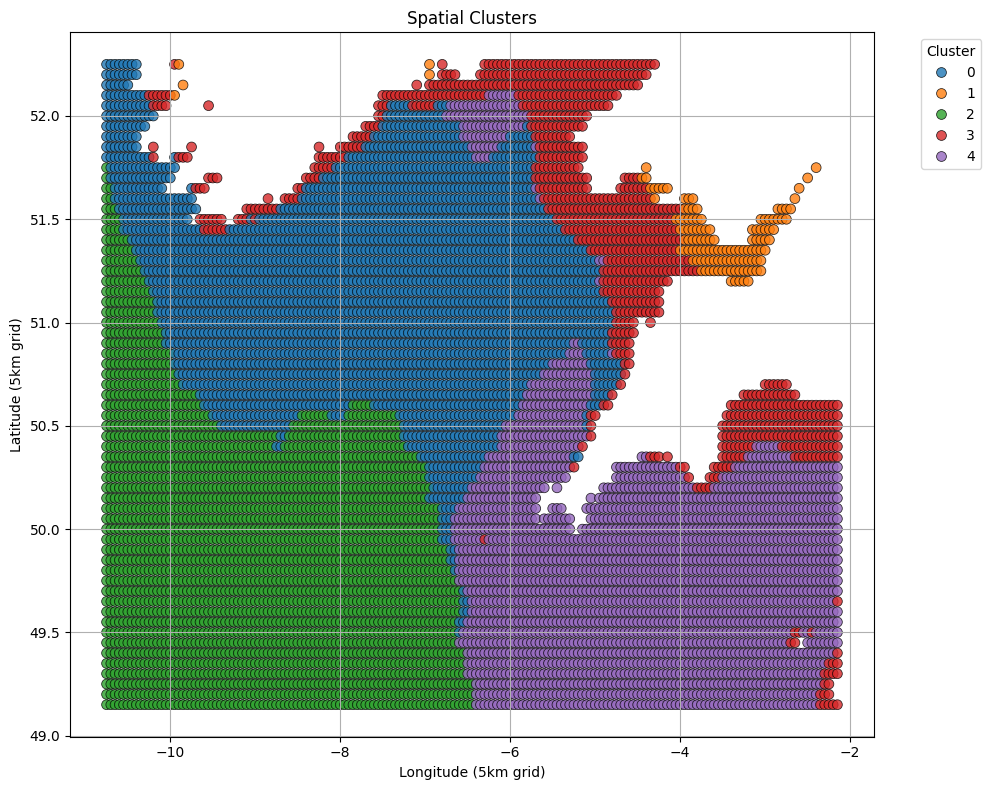

In [ ]:
plot_clusters(cluster_df)

# Step 2: Vector AutoRegression on K-means clusters

In [ ]:
# Prepare containers for results
parameter_columns = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]

# Store lat/lon for heatmap axes
unique_lats = np.sort(train_set['lat_5km'].unique())
unique_lons = np.sort(train_set['lon_5km'].unique())
lag_heatmap = np.full((len(unique_lats), len(unique_lons)), np.nan)

In [ ]:
def train_VAR_per_cluster(train_set, val_set, cluster_map, MAX_lags):
    val_predictions = {}
    train_predictions = {}

    clusters = defaultdict(list)
    for coord, label in cluster_map.items():
        clusters[label].append(coord)

    for cluster_id, points in clusters.items():
        print(f"Cluster {cluster_id} has {len(points)} grid points.")

    cluster_ids = sorted(clusters.keys())
    for cluster_id in tqdm(cluster_ids, desc="Training VAR per cluster"):
        grid_points = clusters[cluster_id]
        if not grid_points:
            continue

        print(f"\nFitting VAR for Cluster {cluster_id} with {len(grid_points)} points")

        cluster_train_series = []
        cluster_val_series = []

        for lat, lon in tqdm(grid_points, desc="Grid points:", leave=False):
            train_ts = train_set[(train_set['lat_5km'] == lat) & (train_set['lon_5km'] == lon)].copy()
            val_ts = val_set[(val_set['lat_5km'] == lat) & (val_set['lon_5km'] == lon)].copy()

            if train_ts.empty:
                continue

            train_ts = train_ts.sort_values('date').drop(['lat_5km', 'lon_5km'], axis=1).set_index('date')
            val_ts = val_ts.sort_values('date').drop(['lat_5km', 'lon_5km'], axis=1).set_index('date')

            cluster_train_series.append(train_ts)
            cluster_val_series.append(val_ts)

        if not cluster_train_series:
            continue

        cluster_train_df = pd.concat(cluster_train_series).groupby('date').mean().sort_index()
        cluster_val_df = pd.concat(cluster_val_series).groupby('date').mean().sort_index()

        if cluster_train_df.isnull().any().any():
            print(f"Skipping Cluster {cluster_id} due to NaNs in training data")
            continue

        train_vals = cluster_train_df.reset_index(drop=True)
        val_vals = cluster_val_df.reset_index(drop=True)

        # Lag selection
        best_aic = np.inf
        best_lag = 1
        for lag in tqdm(range(1, MAX_lags), desc=f"Selecting lag for Cluster {cluster_id}", leave=False):
            try:
                model = VAR(train_vals)
                result = model.fit(lag)
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_lag = lag
            except:
                continue

        # Final model fit
        try:
            model = VAR(train_vals)
            result = model.fit(best_lag)
            print(f"Selected lag {best_lag} for Cluster {cluster_id}")
        except:
            continue

        # Forecast on validation using TRUE lags (one-step-ahead)
        forecast_steps = len(val_vals)
        if forecast_steps > 0:
            preds = []
            # Initialize with training data
            past_values = train_vals.values.copy()

            for step in tqdm(range(forecast_steps), desc=f"Forecasting Cluster {cluster_id}", leave=False):
                # Get the required lags (using true values)
                if step < best_lag:
                    # For first few predictions, combine training and validation data
                    if len(past_values) >= best_lag - step:
                        history = np.vstack([
                            past_values[-(best_lag - step):],
                            val_vals.values[:step]
                        ])
                    else:
                        # Not enough data - skip this point
                        preds.append(np.full(train_vals.shape[1], np.nan))
                        continue
                else:
                    # Use previous 'best_lag' true observations from validation set
                    history = val_vals.values[step - best_lag:step]

                # Forecast one step ahead using true lags
                next_pred = result.forecast(y=history, steps=1)
                preds.append(next_pred[0])

            val_predictions[cluster_id] = np.array(preds)

        # Forecast on training (starting after lag)
        train_preds = []
        for i in range(len(train_vals)):
            if i < best_lag:
                train_preds.append(np.full(train_vals.shape[1], np.nan))  # Not enough context
                continue
            input_window = train_vals.iloc[i - best_lag:i].values
            try:
                pred = result.forecast(y=input_window, steps=1)[0]
            except:
                pred = np.full(train_vals.shape[1], np.nan)
            train_preds.append(pred)

        train_predictions[cluster_id] = np.array(train_preds)

    return val_predictions

# Run the final k-Means + VAR model

In [ ]:
val_predictions_spatial_avg = train_VAR_per_cluster(train_set, val_set, cluster_map, MAX_lags=1)

Cluster 2.0 has 2523 grid points.
Cluster 4.0 has 2277 grid points.
Cluster 3.0 has 910 grid points.
Cluster 0.0 has 2706 grid points.
Cluster 1.0 has 128 grid points.


Training VAR per cluster:   0%|          | 0/5 [00:00<?, ?it/s]


Fitting VAR for Cluster 0.0 with 2706 points



Grid points:: 100%|██████████| 2706/2706 [00:46<00:00, 59.95it/s]
                                                                 
Selecting lag for Cluster 0.0: 0it [00:00, ?it/s]
                                                 

Selected lag 1 for Cluster 0.0



Training VAR per cluster:  20%|██        | 1/5 [00:47<03:09, 47.39s/it]


Fitting VAR for Cluster 1.0 with 128 points



Grid points::  98%|█████████▊| 126/128 [00:02<00:00, 57.71it/s]
                                                               
Selecting lag for Cluster 1.0: 0it [00:00, ?it/s]
Training VAR per cluster:  40%|████      | 2/5 [00:49<01:02, 20.87s/it]


Fitting VAR for Cluster 2.0 with 2523 points



Grid points:: 100%|█████████▉| 2520/2523 [00:43<00:00, 58.60it/s]
                                                                 
Selecting lag for Cluster 2.0: 0it [00:00, ?it/s]
Training VAR per cluster:  60%|██████    | 3/5 [01:34<01:03, 31.58s/it]


Fitting VAR for Cluster 3.0 with 910 points



Grid points:: 100%|█████████▉| 906/910 [00:15<00:00, 57.69it/s]
                                                               
Selecting lag for Cluster 3.0: 0it [00:00, ?it/s]
Training VAR per cluster:  80%|████████  | 4/5 [01:50<00:25, 25.44s/it]


Fitting VAR for Cluster 4.0 with 2277 points



Grid points:: 100%|█████████▉| 2274/2277 [00:40<00:00, 56.96it/s]
                                                                 
Selecting lag for Cluster 4.0: 0it [00:00, ?it/s]
Training VAR per cluster: 100%|██████████| 5/5 [02:30<00:00, 30.09s/it]


In [ ]:
# Save the predictions
joblib.dump(val_predictions_spatial_avg, "/content/drive/MyDrive/LSE Capstone G Drive/Results/K-means + VAR/val_predictions_spatial_avg.joblib")

['/content/drive/MyDrive/LSE Capstone G Drive/Results/K-means + VAR/val_predictions_spatial_avg.joblib']

# Results Visualisation

In [ ]:
train_metrics_k_df = pd.read_csv("/content/drive/MyDrive/LSE Capstone G Drive/Models/kmean/with changes/final_train_metrics_all_k_v4.csv")
val_metrics_k_df = pd.read_csv("/content/drive/MyDrive/LSE Capstone G Drive/Models/kmean/with changes/final_val_metrics_all_k_v4.csv")

In [ ]:
train_metrics_k_df = train_metrics_k_df.reset_index(drop=True)
train_filtered_df = train_metrics_k_df[(train_metrics_k_df["index"]!= 'MAPE (%)') & (train_metrics_k_df["index"]!= 'SMAPE (%)')]

val_metrics_k_df = val_metrics_k_df.reset_index(drop=True)
val_filtered_df = val_metrics_k_df[(val_metrics_k_df["index"]!= 'MAPE (%)') & (train_metrics_k_df["index"]!= 'SMAPE (%)')]

train_filtered_df

index     KD490       ZSD    RRS490    RRS443       CHL     MICRO  \
2   RMSE  0.022421  1.528448  0.001097  0.001174  0.754046  0.930420   
3    MAE  0.009040  0.869762  0.000534  0.000636  0.223109  0.210620   
6   RMSE  0.022534  1.536306  0.001098  0.001176  0.751543  0.920354   
7    MAE  0.009314  0.880346  0.000539  0.000641  0.230074  0.205608   
10  RMSE  0.022286  1.526762  0.001089  0.001169  0.746050  0.916092   
11   MAE  0.009208  0.878834  0.000538  0.000646  0.225721  0.201533   
14  RMSE  0.022303  1.526455  0.001087  0.001168  0.746612  0.917759   
15   MAE  0.009170  0.876645  0.000539  0.000648  0.224865  0.200944   
18  RMSE  0.022293  1.525571  0.001087  0.001167  0.745693  0.918297   
19   MAE  0.009214  0.878179  0.000541  0.000651  0.226170  0.206657   
22  RMSE  0.022205  1.521744  0.001082  0.001161  0.741806  0.909691   
23   MAE  0.009242  0.879075  0.000543  0.000653  0.227075  0.203914   
26  RMSE  0.022020  1.517729  0.001080  0.001159  0.735460  0.903243   
27   MAE  0.009219  0.880775  0.000545  0.000656  0.226209  0.201912   
30  RMSE  0.021979  1.514622  0.001078  0.001156  0.734486  0.900751   
31   MAE  0.009215  0.880403  0.000545  0.000656  0.226025  0.199284   

         BBP       CDM    k  
2   0.003958  0.072738    5  
3   0.001354  0.019099    5  
6   0.003960  0.072235   10  
7   0.001350  0.018915   10  
10  0.003935  0.072059   15  
11  0.001321  0.018680   15  
14  0.003905  0.071970   20  
15  0.001318  0.018857   20  
18  0.003901  0.072019   25  
19  0.001323  0.018837   25  
22  0.003890  0.071740   50  
23  0.001322  0.018952   50  
26  0.003879  0.071444   75  
27  0.001326  0.018818   75  
30  0.003869  0.071415  100  
31  0.001326  0.018831  100

In [ ]:
val_filtered_df

index     KD490       ZSD    RRS490    RRS443       CHL     MICRO  \
2   RMSE  0.023658  1.501451  0.001448  0.001510  0.774189  3.677433   
3    MAE  0.009457  0.870399  0.000750  0.000851  0.236290  0.969033   
6   RMSE  0.023778  1.514797  0.001431  0.001510  0.774732  3.708612   
7    MAE  0.009793  0.883465  0.000748  0.000851  0.245638  0.948715   
10  RMSE  0.025408  1.557404  0.001400  0.001500  0.823625  3.719716   
11   MAE  0.010176  0.898454  0.000734  0.000851  0.258095  0.950329   
14  RMSE  0.026053  1.563828  0.001405  0.001493  0.843721  3.736993   
15   MAE  0.010272  0.896469  0.000736  0.000852  0.262215  0.953952   
18  RMSE  0.025938  1.579349  0.001462  0.001538  0.839976  3.743537   
19   MAE  0.010347  0.907787  0.000750  0.000863  0.264307  0.965244   
22  RMSE  0.027460  1.599679  0.001494  0.001582  0.887820  3.789285   
23   MAE  0.010494  0.914864  0.000754  0.000867  0.267665  0.973163   
26  RMSE  0.025063  1.556440  0.001521  0.001610  0.824061  3.811900   
27   MAE  0.010222  0.913664  0.000759  0.000873  0.258188  0.972894   
30  RMSE  0.026169  1.562239  0.001476  0.001571  0.866540  3.796236   
31   MAE  0.010396  0.917711  0.000751  0.000867  0.264198  0.966384   

         BBP       CDM    k  
2   0.004627  0.069517    5  
3   0.001770  0.019038    5  
6   0.004611  0.069002   10  
7   0.001781  0.018823   10  
10  0.004427  0.069865   15  
11  0.001681  0.018763   15  
14  0.004352  0.070428   20  
15  0.001671  0.018948   20  
18  0.004438  0.070396   25  
19  0.001677  0.018629   25  
22  0.004816  0.071778   50  
23  0.001761  0.019654   50  
26  0.004861  0.070871   75  
27  0.001756  0.019125   75  
30  0.005085  0.072639  100  
31  0.001778  0.019431  100

## Plot the validation RMSE and MAE metrics to select the best k

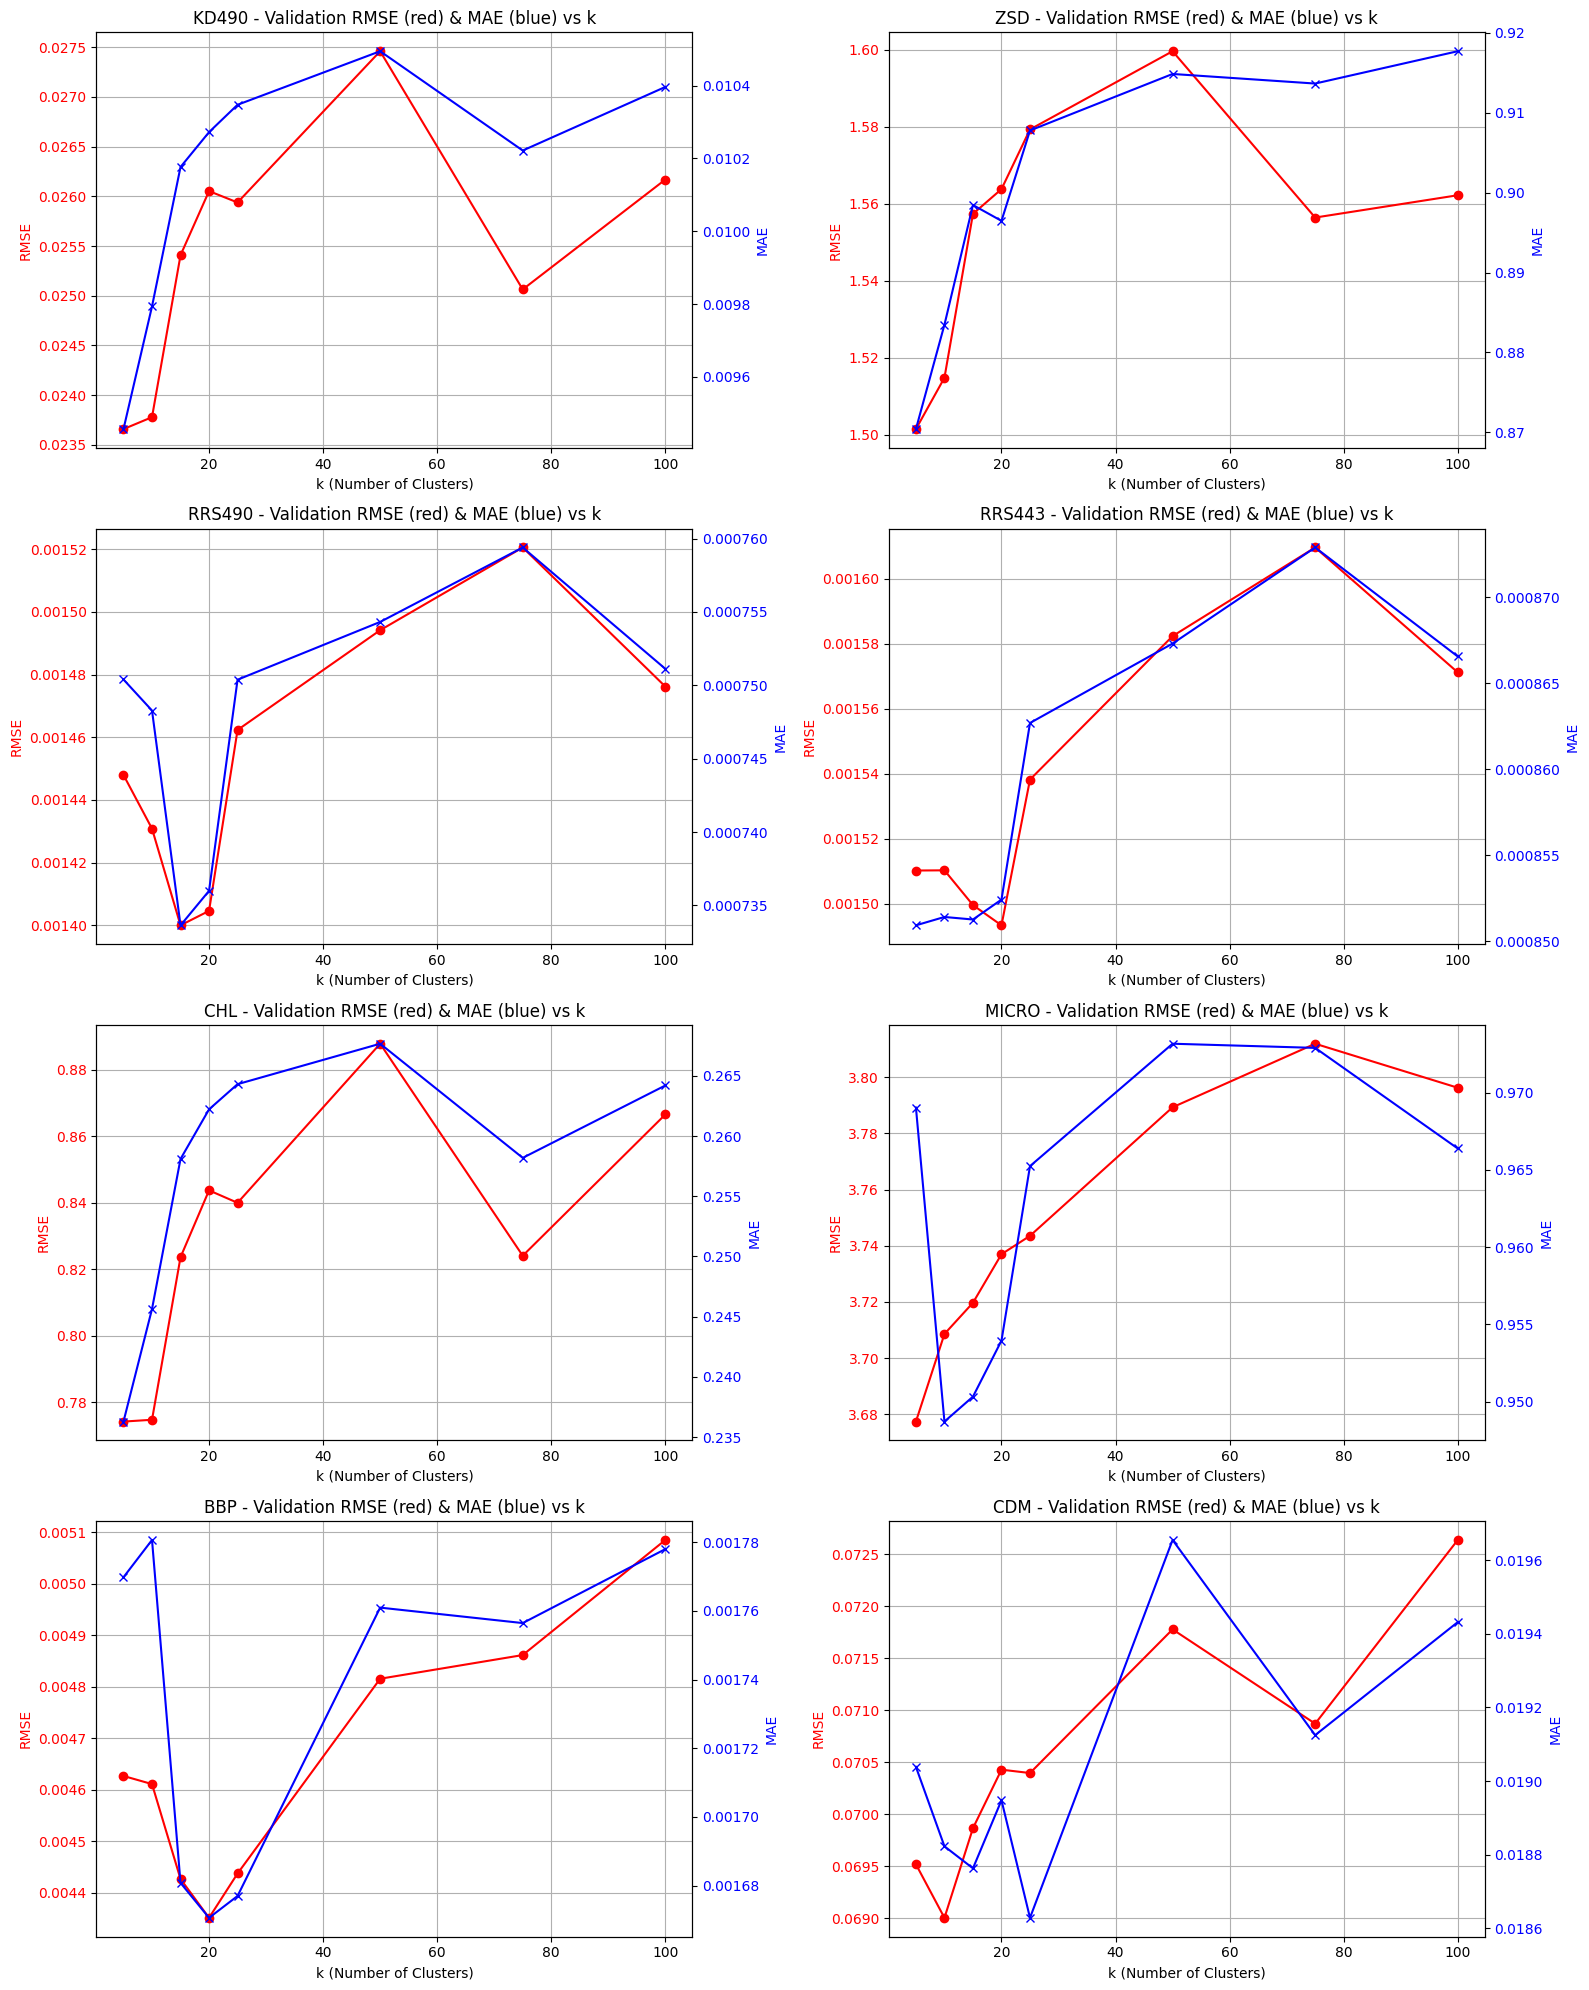

In [ ]:
variables = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, var in enumerate(variables):
    ax1 = axes[i]

    # Extract validation RMSE and MAE for this variable
    val_rmse = val_filtered_df[val_filtered_df['index'] == 'RMSE'][['k', var]].sort_values('k')
    val_mae  = val_filtered_df[val_filtered_df['index'] == 'MAE'][['k', var]].sort_values('k')

    # Plot RMSE on left y-axis
    ax1.plot(val_rmse['k'], val_rmse[var], color='red', marker='o', label='RMSE')
    ax1.set_ylabel('RMSE', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Create second y-axis for MAE
    ax2 = ax1.twinx()
    ax2.plot(val_mae['k'], val_mae[var], color='blue', marker='x', label='MAE')
    ax2.set_ylabel('MAE', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax1.set_title(f"{var} - Validation RMSE (red) & MAE (blue) vs k")
    ax1.set_xlabel('k (Number of Clusters)')
    ax1.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## Check predictive accuracy of the model (k=5) by plotting the true vs predicted values

In [ ]:
def plot_spatially_averaged_predictions(val_set, val_predictions, parameter_columns, cluster_map):
    """
    Plot spatially averaged predictions and truth for each cluster in 4x2 subplots.
    Shows all 8 variables' time series for each cluster.
    """
    # Create mapping from cluster to grid points
    cluster_to_points = defaultdict(list)
    for (lat, lon), cluster in cluster_map.items():
        cluster_to_points[cluster].append((lat, lon))

    # Plot for each cluster
    for cluster_id, preds in val_predictions.items():
        grid_points = cluster_to_points[cluster_id]

        # Collect all true values for this cluster
        all_truths = []
        valid_dates = None
        for lat, lon in grid_points:
            val_ts = val_set[(val_set['lat_5km'] == lat) & (val_set['lon_5km'] == lon)]
            if len(val_ts) == 0:
                continue
            val_ts = val_ts.sort_values('date')
            if valid_dates is None:
                valid_dates = val_ts['date'].values
            all_truths.append(val_ts[parameter_columns].values)

        if len(all_truths) == 0:
            continue

        # Average truths across grid points in cluster
        avg_truths = np.stack(all_truths).mean(axis=0)

        # Create figure with 4x2 subplots
        fig, axes = plt.subplots(4, 2, figsize=(20, 20))
        axes = axes.flatten()

        # Plot each parameter
        for i, param in enumerate(parameter_columns):
            ax = axes[i]
            ax.plot(valid_dates, avg_truths[:, i], label='True', color='blue', linewidth=1.5)
            ax.plot(valid_dates, preds[:, i], label='Predicted', color='red', linestyle='--', linewidth=1)
            ax.set_title(param, fontsize=12)
            ax.set_xlabel('Date', fontsize=10)
            ax.set_ylabel('Value', fontsize=10)
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)

            # Rotate x-axis labels
            for label in ax.get_xticklabels():
                label.set_rotation(45)
                label.set_horizontalalignment('right')

        plt.suptitle(f'Cluster {cluster_id} - True vs Predicted Values\n'
                    f'({len(grid_points)} grid points averaged)',
                    y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()

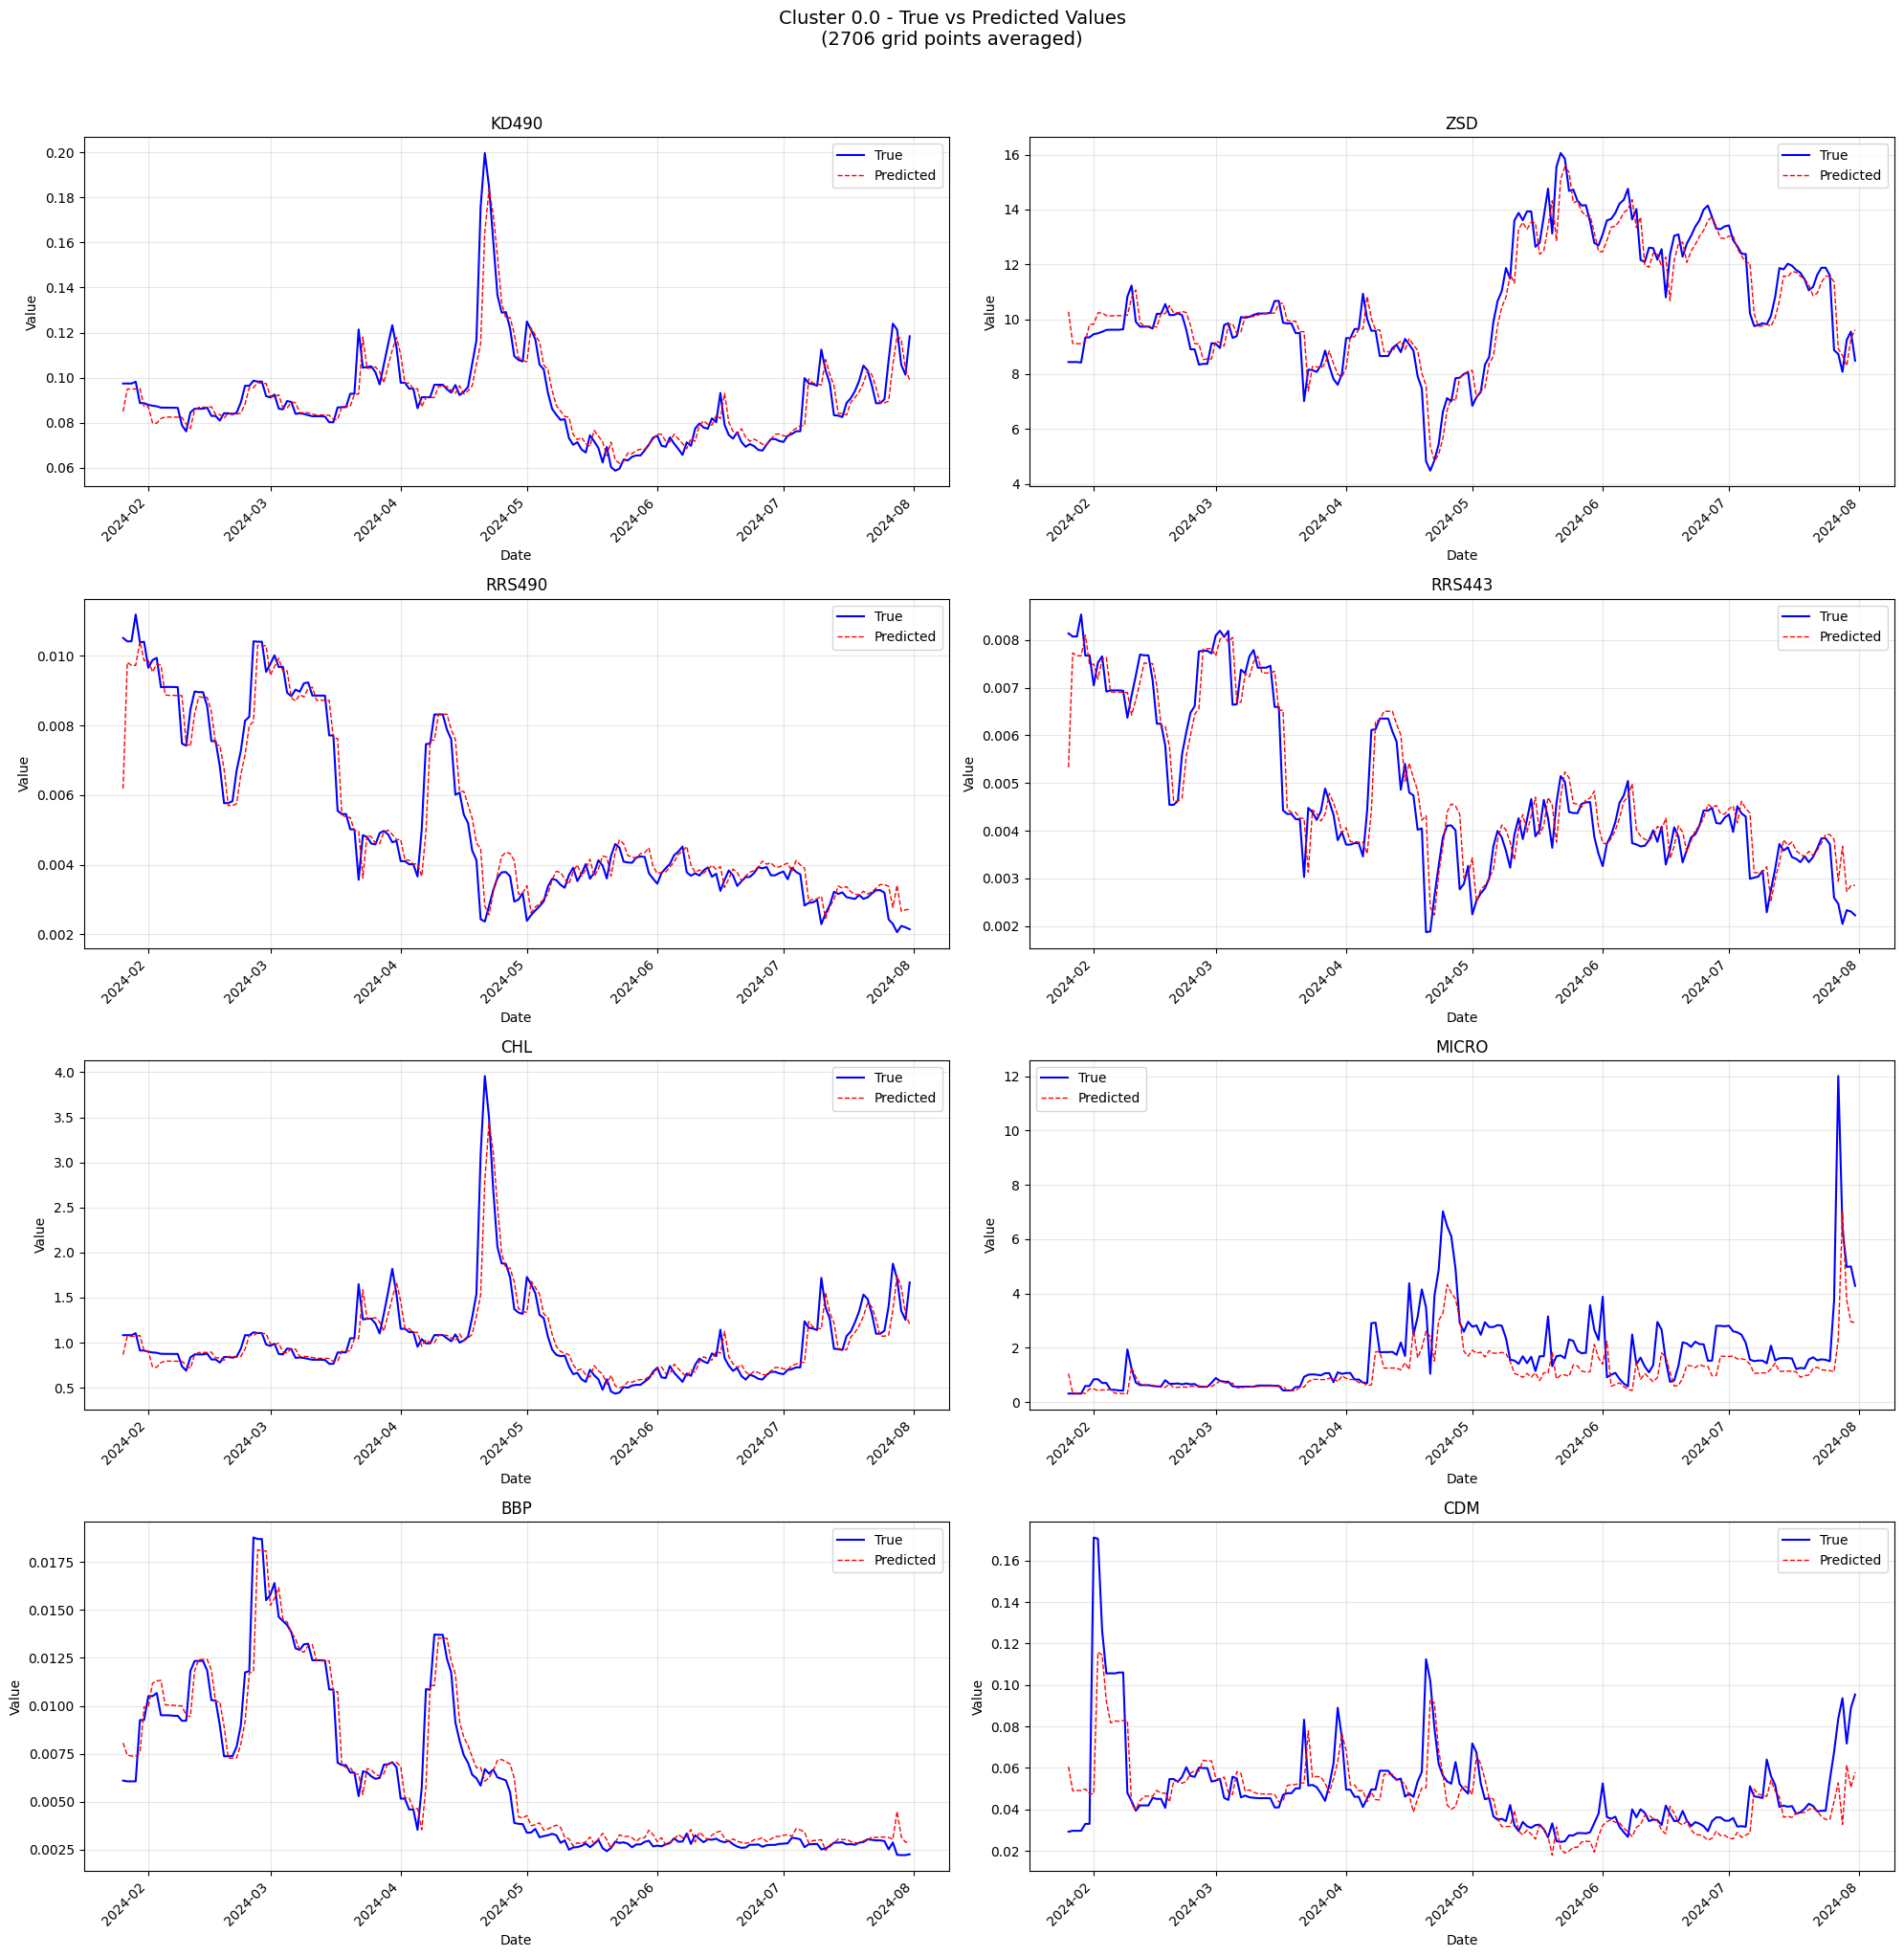

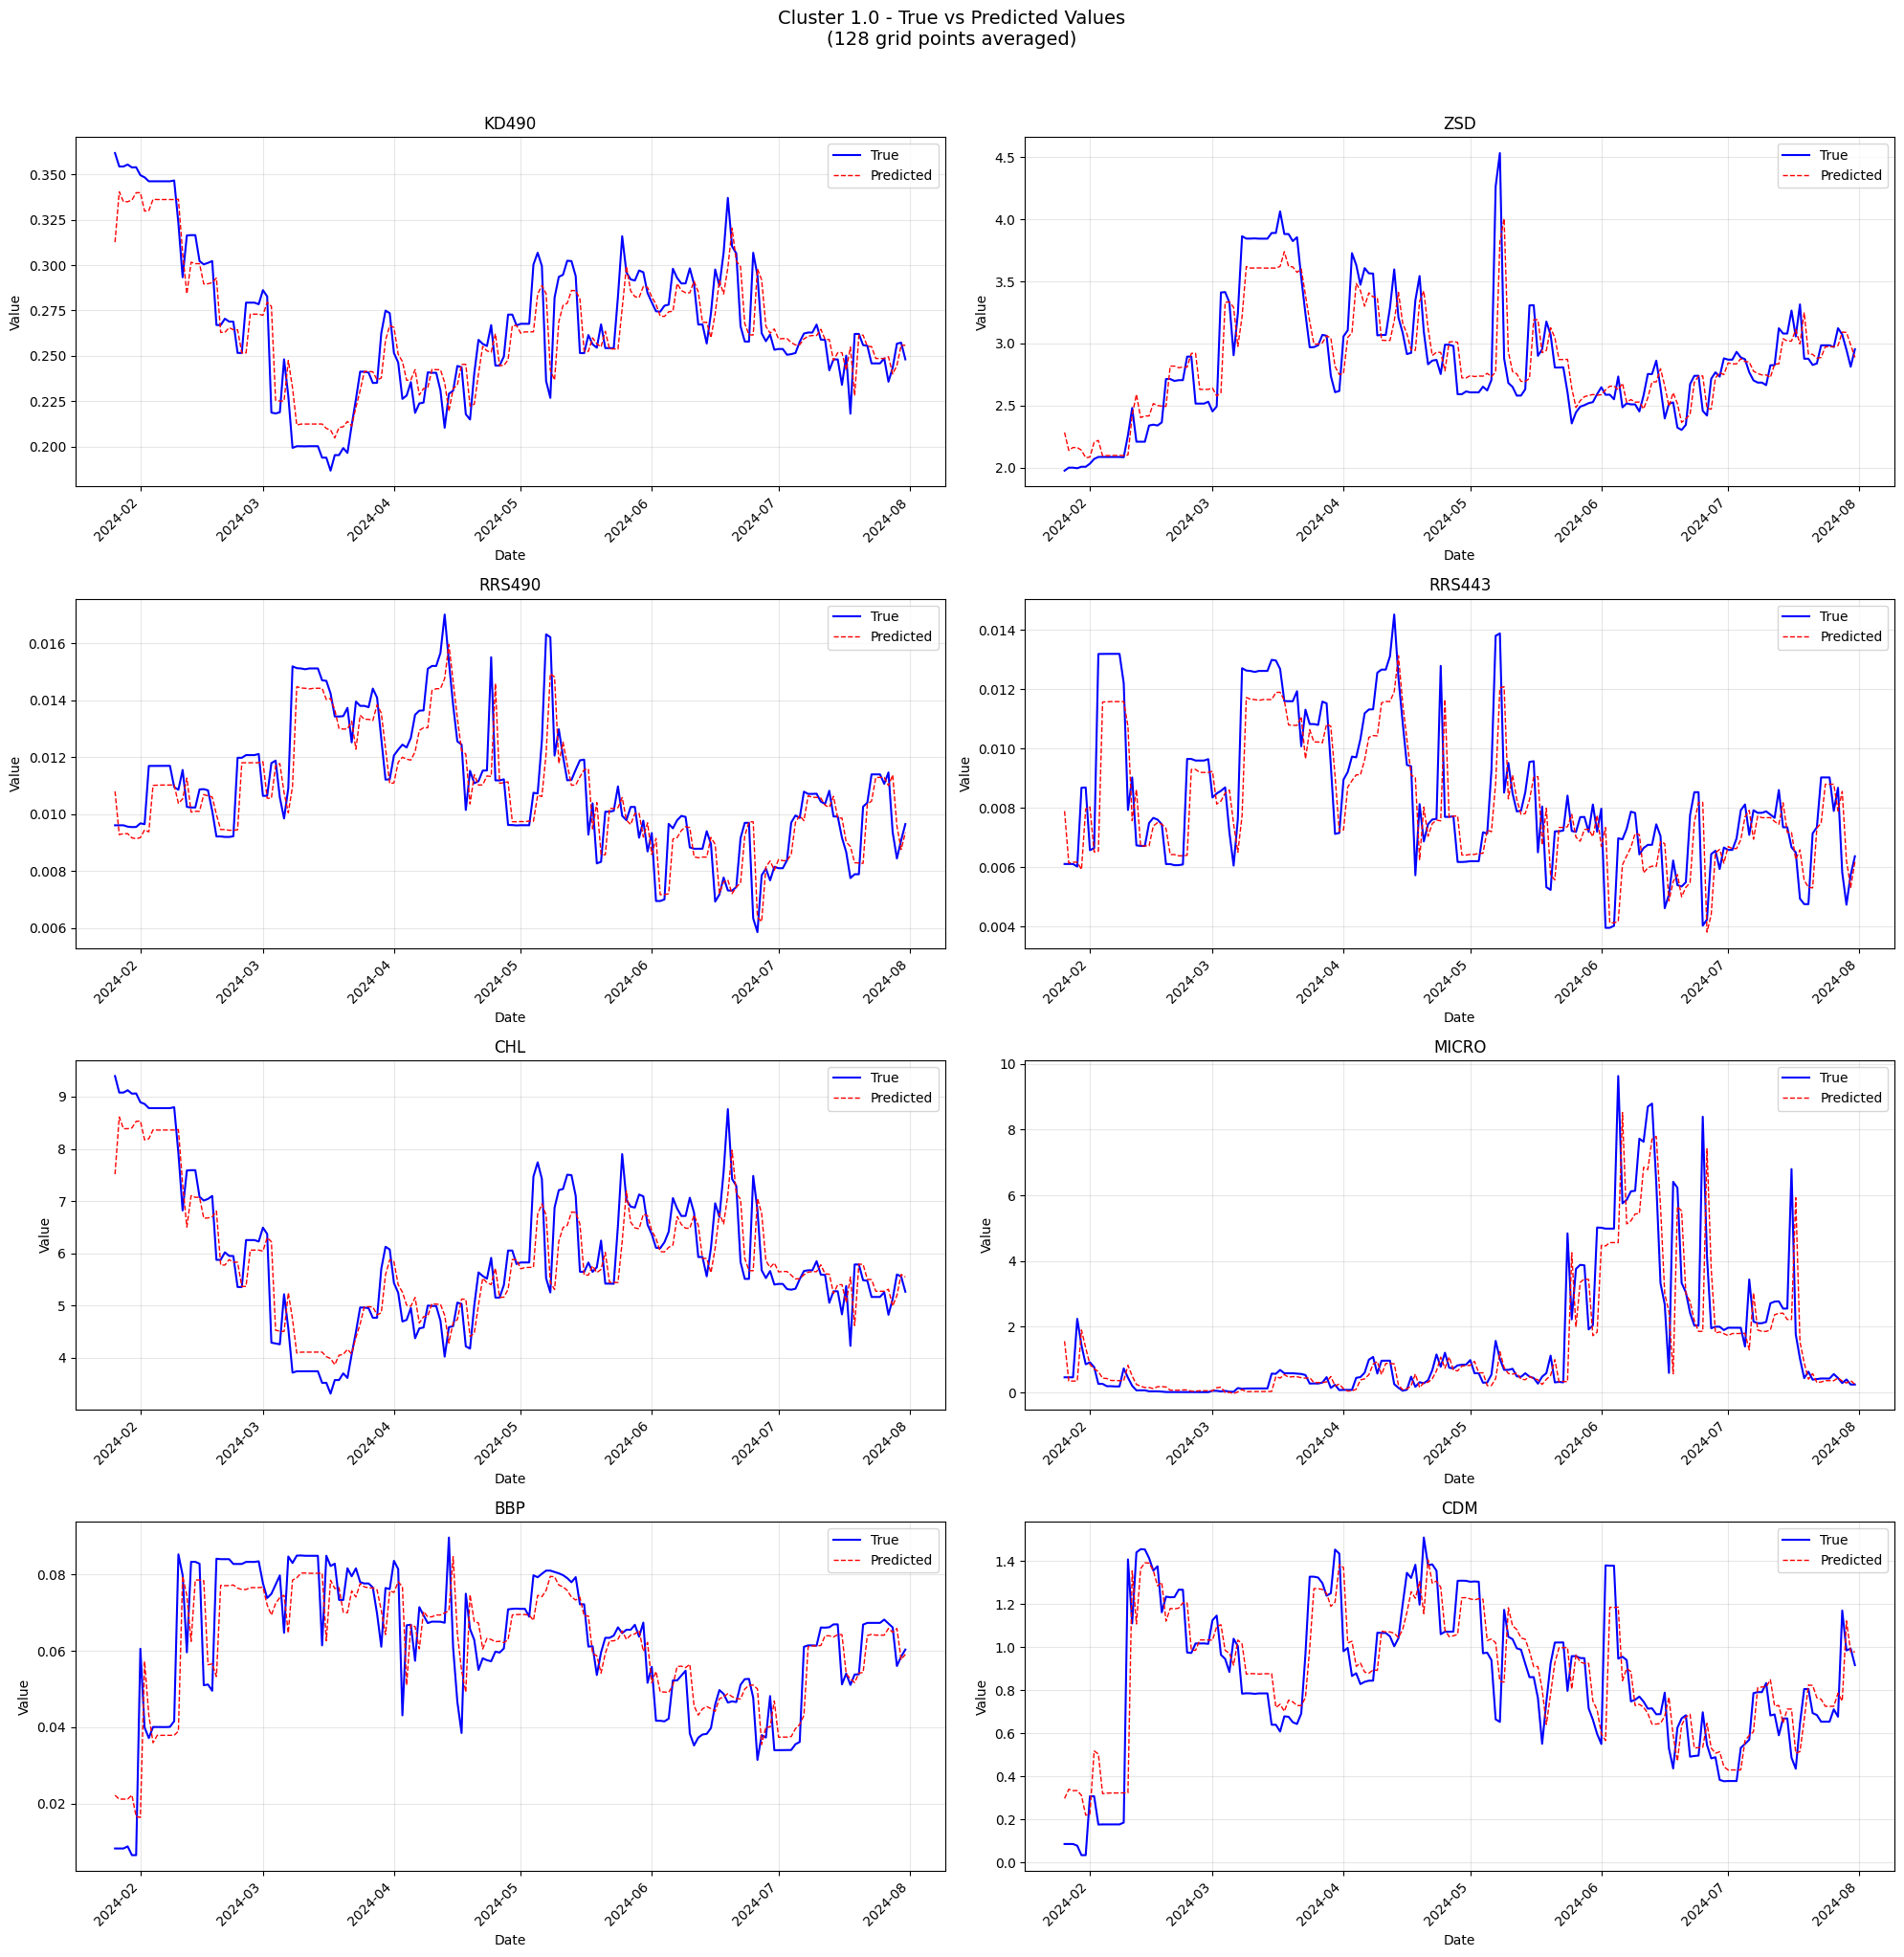

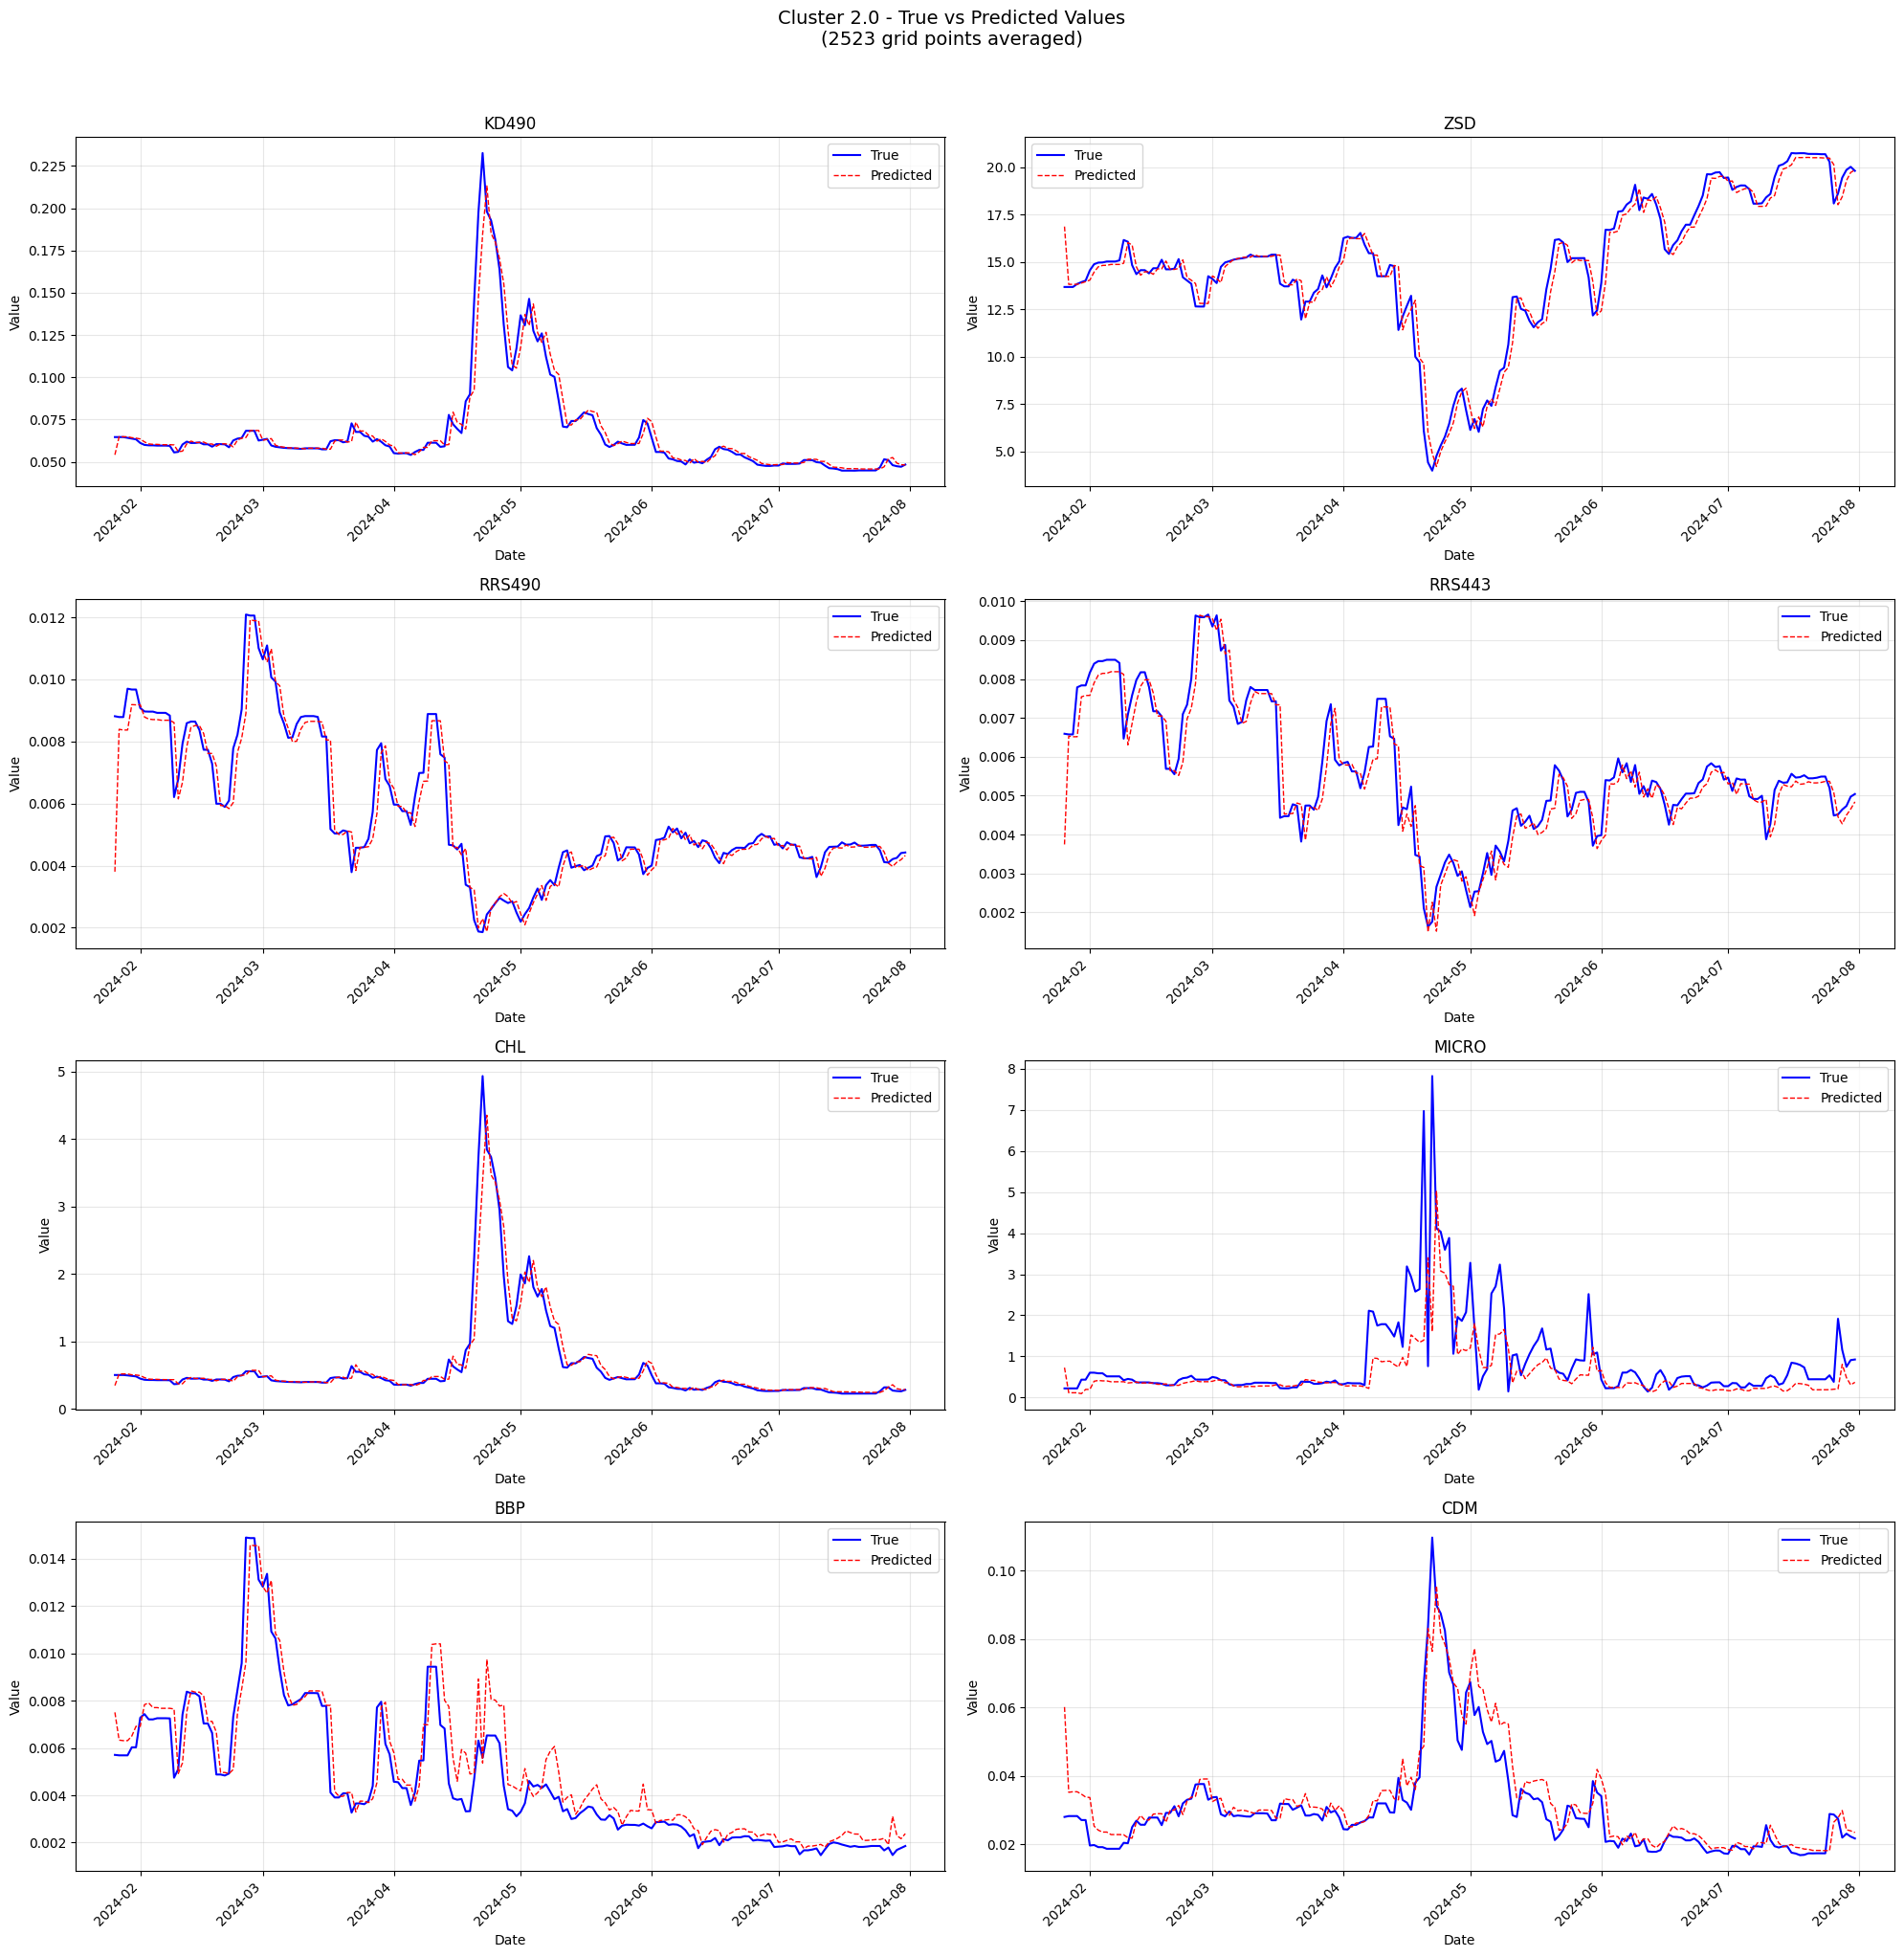

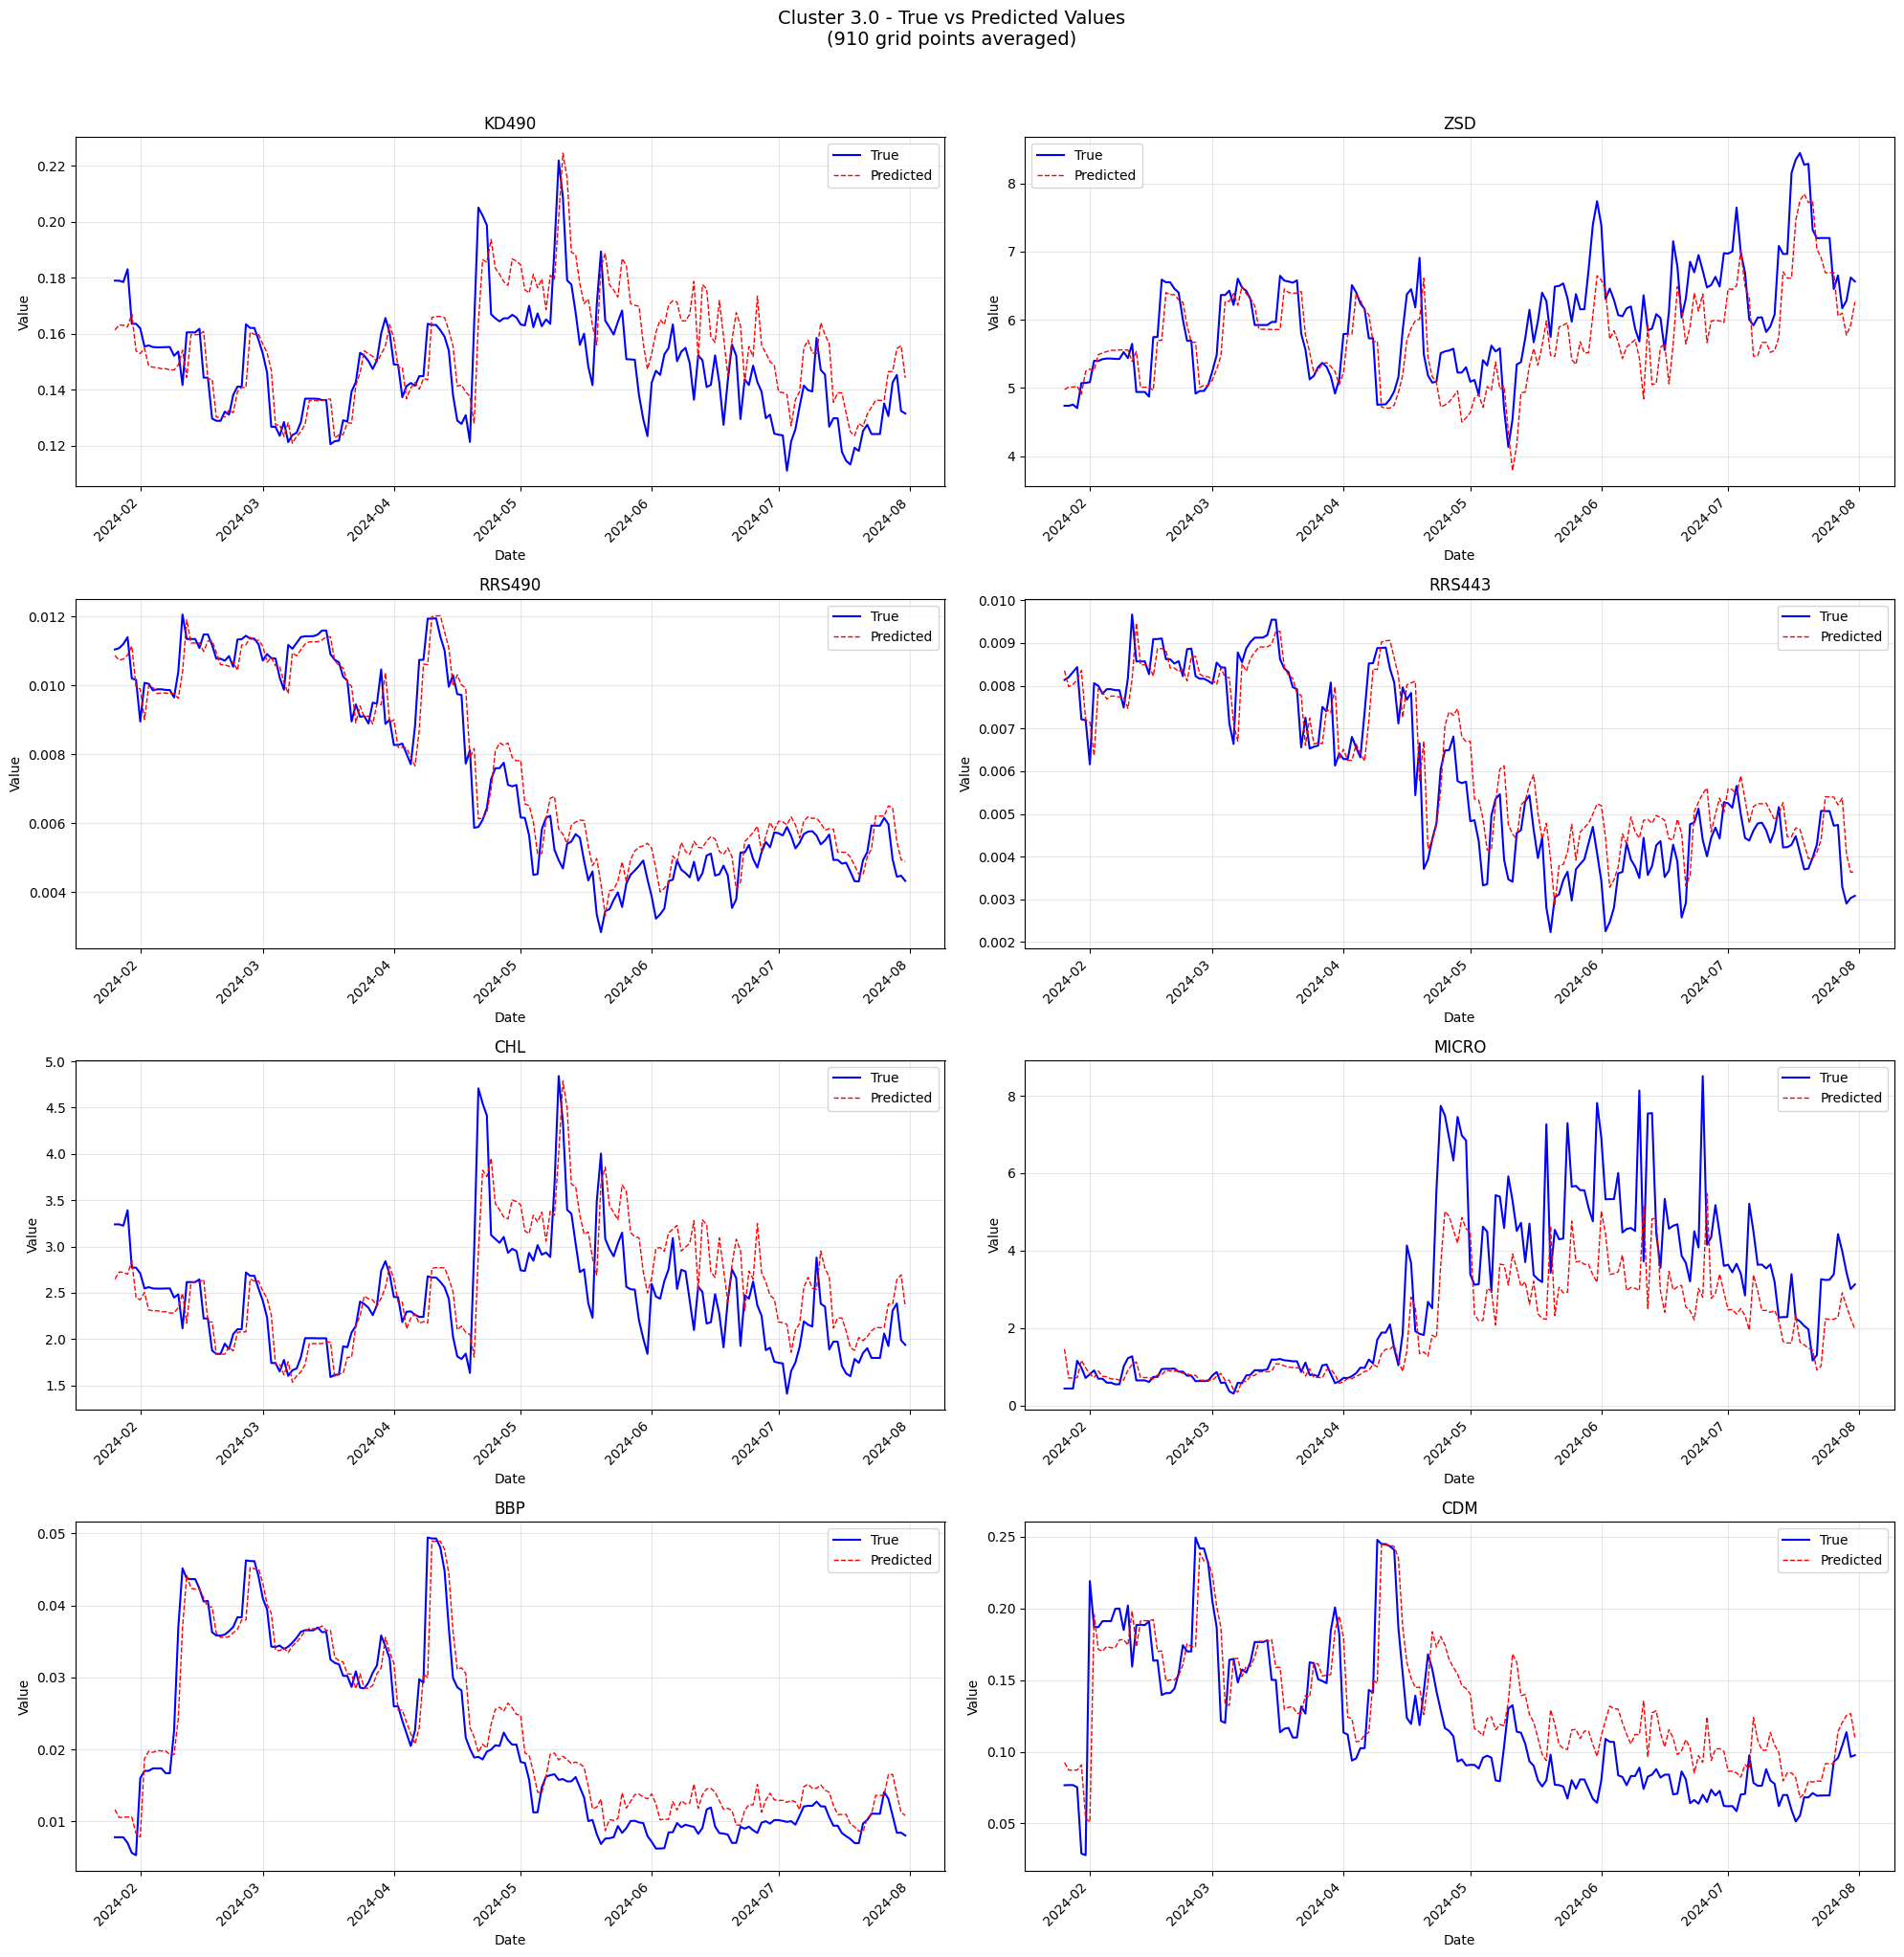

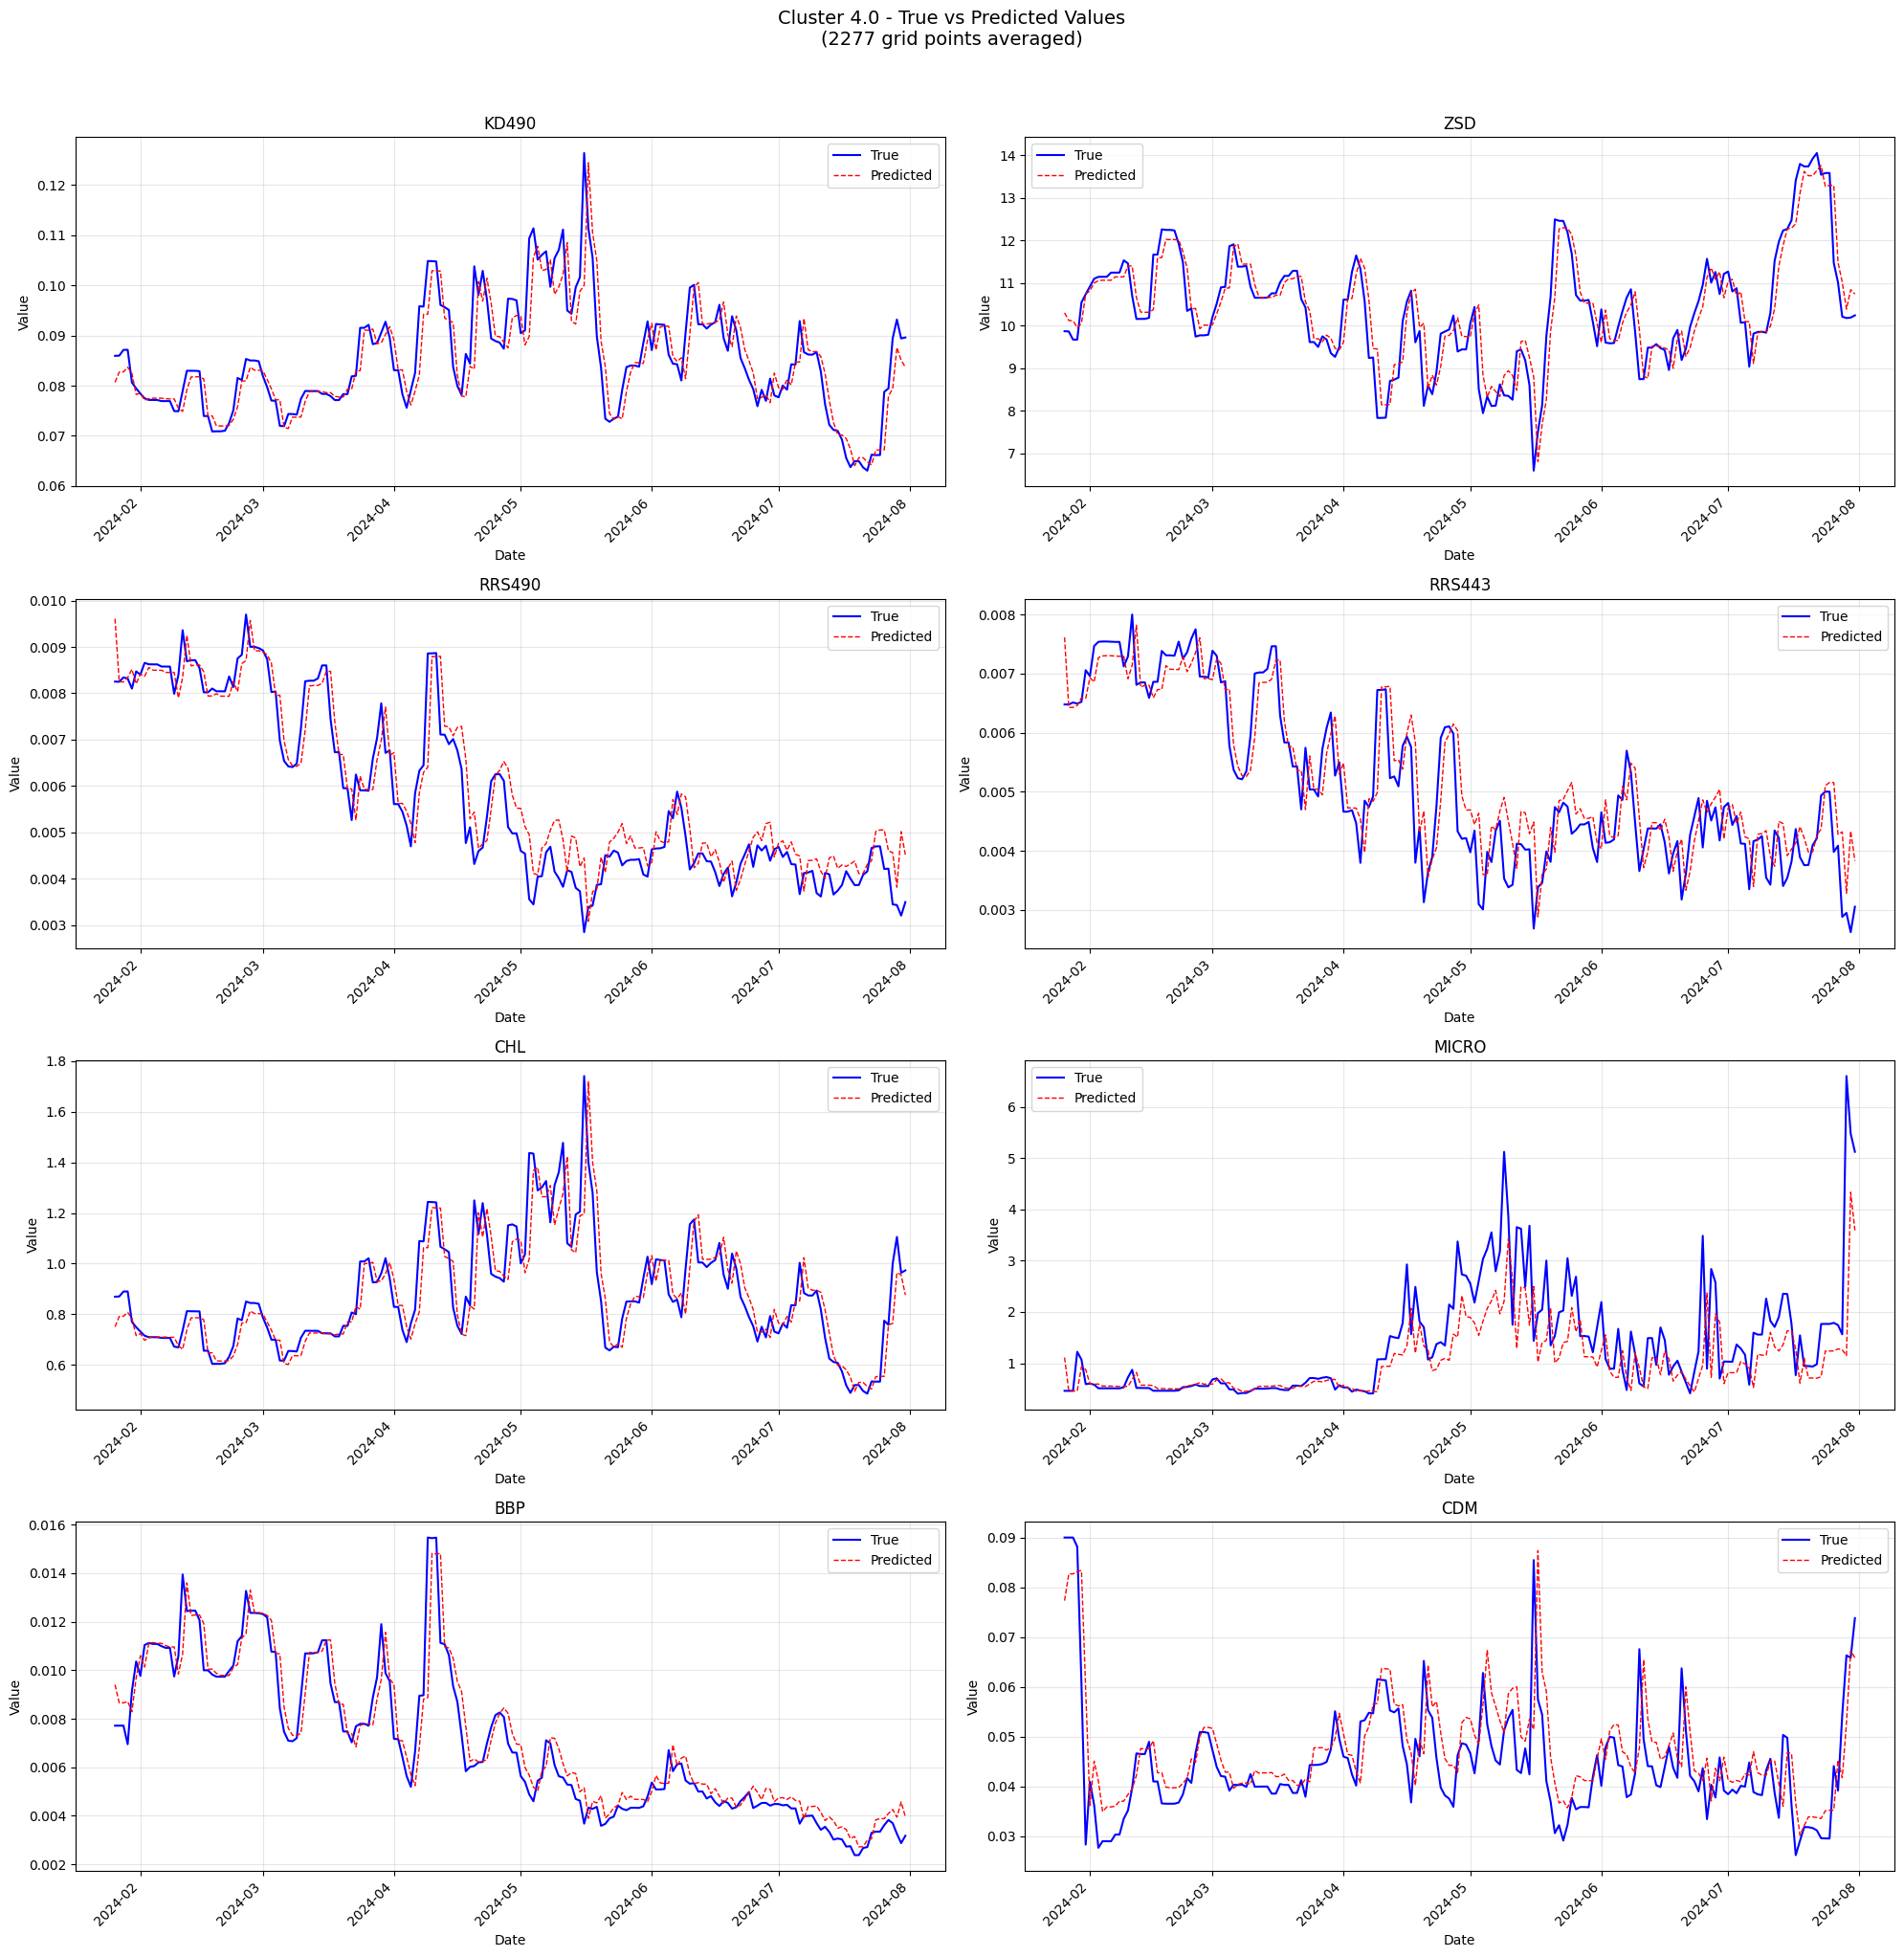

In [ ]:
parameter_columns = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]
plot_spatially_averaged_predictions(val_set, val_predictions_spatial_avg, parameter_columns, cluster_map)

## Calculate the metrics: SMAPE, RMSE, MAE and plot heatmap

In [ ]:
def calculate_cluster_metrics(val_set, val_predictions, parameter_columns, cluster_map):
    """
    Calculate global metrics following your structure but adapted for cluster-level predictions

    Returns:
    - metrics_df: DataFrame with metrics for each variable
    - all_preds: All predicted values stacked (N, 8)
    - all_truths: All true values stacked (N, 8)
    """
    # Create mapping from cluster to grid points
    cluster_to_points = defaultdict(list)
    for (lat, lon), cluster in cluster_map.items():
        cluster_to_points[cluster].append((lat, lon))

    # Initialize storage
    all_preds, all_truths = [], []

    # Aggregate predictions and truths
    for cluster_id, cluster_preds in val_predictions.items():
        grid_points = cluster_to_points[cluster_id]

        # Get true values for all grid points in this cluster
        for lat, lon in grid_points:
            val_ts = val_set[(val_set['lat_5km'] == lat) & (val_set['lon_5km'] == lon)]
            if len(val_ts) == 0:
                continue

            val_ts = val_ts.sort_values('date')[parameter_columns].values

            # Match shapes (cluster_preds is T×8, val_ts should be T×8)
            if cluster_preds.shape != val_ts.shape:
                continue

            all_preds.append(cluster_preds)
            all_truths.append(val_ts)

    if not all_preds:
        print("Warning: No valid predictions found")
        return None, None, None

    # Stack all predictions and truths
    all_preds = np.vstack(all_preds)    # (N, 8)
    all_truths = np.vstack(all_truths)  # (N, 8)

    # Clip small values to avoid division issues
    clipped_truths = np.clip(np.abs(all_truths), 1e-8, None)
    sum_abs = np.clip(np.abs(all_truths) + np.abs(all_preds), 1e-8, None)

    # Calculate metrics
    global_mape = np.mean(np.abs((all_truths - all_preds) / clipped_truths), axis=0) * 100
    global_rmse = np.sqrt(np.mean((all_truths - all_preds) ** 2, axis=0))
    global_mae = np.mean(np.abs(all_truths - all_preds), axis=0)
    global_smape = np.mean(2 * np.abs(all_truths - all_preds) / sum_abs, axis=0) * 100

    # Create metrics DataFrame
    metrics_df = pd.DataFrame(
        [global_mape, global_smape, global_rmse, global_mae],
        index=['MAPE (%)', 'SMAPE (%)', 'RMSE', 'MAE'],
        columns=parameter_columns
    )

    return metrics_df

def plot_metrics_heatmap(metrics_df):
    """Plot the metrics as a heatmap"""
    plt.figure(figsize=(12, 4))
    sns.heatmap(metrics_df, annot=True, fmt=".3f", cmap='coolwarm',
                cbar_kws={'label': 'Error Value'})
    plt.title("Global Metrics per Variable, k-means + VAR with spatial averaging")
    plt.xlabel("Variable")
    plt.ylabel("Metric")
    plt.tight_layout()
    plt.show()

In [ ]:
metrics_df = calculate_cluster_metrics(val_set, val_predictions_spatial_avg, parameter_columns, cluster_map)
metrics_df

KD490        ZSD     RRS490     RRS443        CHL      MICRO  \
SMAPE (%)  20.495338  22.477180  27.890747  30.009834  38.684393  88.438869   
RMSE        0.036388   3.039185   0.002284   0.002090   1.119031   4.815697   
MAE         0.020772   2.313618   0.001621   0.001523   0.480740   1.532828   

                 BBP        CDM  
SMAPE (%)  45.298623  38.819525  
RMSE        0.007013   0.109879  
MAE         0.003806   0.031524

In [ ]:
metrics_df = calculate_cluster_metrics(val_set, val_predictions_spatial_avg, parameter_columns, cluster_map)
metrics_df

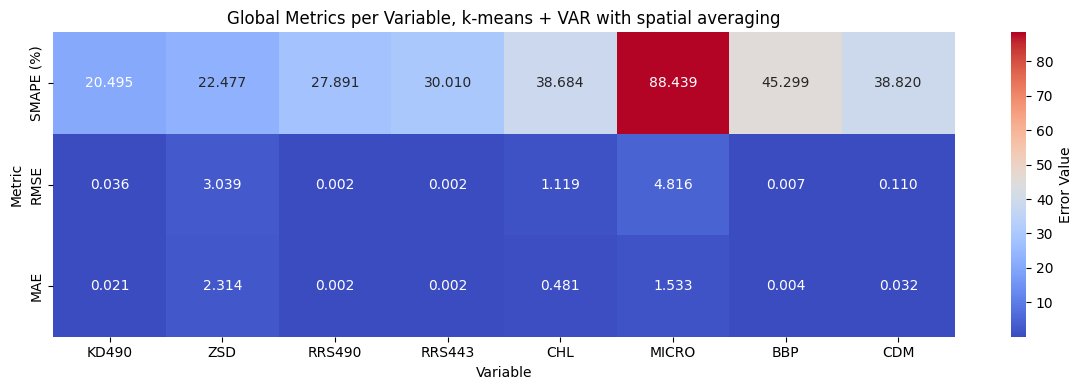

In [ ]:
plot_metrics_heatmap(metrics_df)